# Future Learn MOOC - Activity and Confidence Analysis
### (Default Analysis Notebook)

From data on people that participated in a MOOC (Massive Open Online Course)
we attempt to retrieve insights.
The objective is to both: analyze the data from a run of such a MOOC,
and also build a reasonably reusable tool to perform further
analysis on similar data.
We attempt to build a reasonably general data analysis tool that will
allow a user to edit a few calls to output graphs with new relations.
Also, we attempt to make the code robust enough so it does not
rust too quickly with new data and new library updates.

A conservative approach as to what libraries to use will
allow for a longer life of the code.
We only use full version libraries,
which should hence be always backward compatible with the same major versions.
In our case any version of `numpy` 1, `pandas` 1 and `matplotlib` 3
shall run the code without issues.
We also avoid the `seaborn` library in order to keep the code running
for as long as possible, the `seaborn` library has not yet fully
defined its interfaces.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
np.__version__, pd.__version__, matplotlib.__version__

('1.18.1', '1.0.1', '3.1.3')

Further we divide the work in three distinct parts.
The `jupyter` notebook in which the work is contained follow the rule
of placing dependencies above the dependent code,
hence - even if the notebook appear to be run - one needs to
run the cells above the current cell in order for the code to work.
Remember that all code state is forgotten once you shutdown `jupyter` notebook/lab,
in which case the notebook needs to be re-run.
The parts of the notebook follow:

- The *Data Model* which consist of packaging the data we have into a consistent set of tables.
  For any compatible dataset this part will need to be reworked.
  Yet, once the dataset fits into the data model further analysis parts should just work.

- *General Analysis* build the common, and rather general, graphs about the participants of the MOOC.
  We build a few graphic tools along the way, tools that will be used in the following part.

- *Extra Analysis* is the part in which one can use the tools provided in the previous part
  to build his own graphs from the given data.
  The data processing in the *Data Model* part allows for extra columns to be passed
  all the way through the processing chain, this allows to build new graphs by just adding data.

![Windmill](mooc-confidence-fl-windmill.svg)

<div style="text-align:right;"><sup>mooc-confidence-fl-windmill.svg</sup></div>

---

## Part 1: Data Model

In order to make the code as reusable as possible we establish a data model to follow.
The operations on data will build a few common names which then will never be
changed throughout the remaining of the code.
Such discipline will allow us to reuse all analysis and graphics operations on a new
set of data, provided we can fit the new set into the same data model.

The model itself will consist on a few tables:

- A fact table called `response`,
  with one main foreign key called `participant_id`,
  it represents the activity and responses of participants to the activity steps.

- A second fact table called `step` will follow the same model,
  it will have the main foreign key as `participant_id` as well.

- The main dimension will be called `participant` and use `participant_id` as its primary key.
  The `participant` dimension will aggregate unto itself everything we know about each
  participant from all source of data.

Both `response` and `step` facts will contain a time dimension upon themselves
called `week`, a numeric and ascending value to filter against.
In the `response` fact the primary key will be the uniqueness of `participant_id`,
`week`, `step` and `question`.
And in the `step` fact the primary key will be `participant_id`, `week` and `step`.

Albeit the two fact tables seem redundant to a good extent,
the reason for the separation is that several participants may
attend the MOOC but not answer the questions.
The `response` fact accounts for more granular information on diligent participants,
whilst the `step` fact accounts for all participants,
including participants who only clicked on a few steps and gave up.

There is nothing holding the uniqueness of the keys described
since we use pandas and not a SQL database.
The onus on verifying the uniqueness is on the user.
We add a few sanity checks after the data processing for this purpose,
and these shall catch a good deal of issues if such appear.

### Current Data

In order to fit our data model we build the fact and dimension as follows:

- `participant` is built from `enrolments` data joined with the `archetype-survey`.
  the primary key `learner_id` is renamed to `participant_id`.

- `response` is constructed from the `question-response` data and joined with
  `step-activity` and aggregated `comments`.  It's foreign key `learner_id`
  is renamed to `participant_id`.

- a third fact table `comment` is built from comments data and linked to the
  `participant` dimension.  The `author_id` foreign key is renamed to `participant_id`
  for the linking purpose.  This extra table is unlikely to appear in a different
  data set hence we leave it out of the data model.  There is also no
  uniqueness (or primary key) for this data.

Note that all joins will be left joins from the `participant` dimension
onto the fact tables, thus avoiding missing data on the dimension side.

### Loading the data

**The names of the CSV files may differ**, one must remember to verify the file names,
which must live in the same directory as the notebook.
**Also note that the filenames have the name of the MOOC course removed.**
The `parse_dates=` parameters are used for date and time columns,
and allow us to work with times in an easier fashion.
Whilst the `index_col=` takes the column with unique values,
sometimes there is no column with unique values and sometimes
the unique values are just meaningless `ID` numbers.

In [2]:
archetype = 'archetype-survey-responses.csv'
remark = 'comments.csv'
country = 'countries.csv'
enrol = 'enrolments.csv'
question = 'question-response.csv'
activity = 'step-activity.csv'
video = 'video-stats.csv'
archetype = pd.read_csv(archetype, index_col='learner_id', parse_dates=['responded_at'])
remark = pd.read_csv(remark, index_col='id', parse_dates=['timestamp'])
country = pd.read_csv(country, index_col='country_code')
enrol = pd.read_csv(enrol, index_col='learner_id', parse_dates=['enrolled_at', 'fully_participated_at'])
question = pd.read_csv(question, parse_dates=['submitted_at'])
activity = pd.read_csv(activity, parse_dates=['first_visited_at', 'last_completed_at'])
video = pd.read_csv(video)

### Sanity Checks

A few assumptions are made about the data before we process it.
Some of these sanity checks will be repeated once we transition into
the data model specified above but the earlier we find possible issues the better.
**Each of the tests below should not fail and should return `True`.**
If that is not the case then one must go back to the files and rectify.

There is only one type of question, namely multiple choice.

In [3]:
len(question.question_type.unique()) ==  1

True

IDs for participants are unique.

In [4]:
len(enrol.index.unique()) == len(enrol)

True

Indexes such as weeks and steps must be integers.
Note that this also means that there are no null values
as `numpy` does not allow for null integers.

In [5]:
pd.api.types.is_integer_dtype(question.week_number)

True

In [6]:
pd.api.types.is_integer_dtype(question.step_number)

True

In [7]:
pd.api.types.is_integer_dtype(question.question_number)

True

In [8]:
pd.api.types.is_integer_dtype(activity.week_number)

True

In [9]:
pd.api.types.is_integer_dtype(activity.step_number)

True

### Transform (into the Data Model)

Now we can place the data we have into the data model we defined.
The naming convention is that we will never use the same variable
name for the loaded data and the data model table,
this naming convention ensures that code cells can be re-run
without too much care for the order in which they are re-run.

First we build the `comment` extra fact table.
The table is not part of the data model but its contents will prove
useful to enrich tables from the data model itself.
We do not do many changes to the `comment` table from the CSV file.

In [10]:
comment = remark.copy()
comment.drop('step', axis=1, inplace=True)
comment = comment.rename(columns={
    'author_id': 'participant_id',
    'week_number': 'week',
    'step_number': 'step',
})
comment['text_length'] = comment.text.str.len()
cols = [i for i in comment.columns if i != 'text']  # prevent personal info leak
comment[cols][:3]

,participant_id,parent_id,week,step,timestamp,likes,first_reported_at,first_reported_reason,moderation_state,moderated,text_length
id,,,,,,,,,,,
59104690,0022e782-f726-4682-9a91-adb8401df949,NaN,1,1,2021-05-03 06:19:13+00:00,1,NaN,NaN,NaN,NaN,300
59107936,ee7d449b-e4c5-44af-a890-61680d001828,NaN,1,1,2021-05-03 08:58:58+00:00,2,NaN,NaN,NaN,NaN,446
59110647,d8f579a6-d8a2-4842-a4ea-cf6ecfa2d101,59104690.0,1,1,2021-05-03 10:45:09+00:00,1,NaN,NaN,NaN,NaN,136


And we can now build the `participant` dimension,
while at the same time enrich it with data from the archetype survey
and the step comments.

The `participant` dimension defines all information we have about the participants,
if more data about the participant themselves becomes available we can
further extend this table with more columns.

In [11]:
arch = archetype.reset_index().sort_values(by='responded_at', ascending=False).groupby('learner_id').first()
participant = enrol.join(arch)
participant = participant.rename_axis('participant_id')
tmp = comment.rename(columns={'step': 'total_comments'}).groupby(['participant_id']).count()['total_comments']
participant = participant.join(tmp)
participant['total_comments'].fillna(0, inplace=True)
tmp = comment.rename(columns={'likes': 'total_likes'}).groupby(['participant_id']).sum()['total_likes']
participant = participant.join(tmp)
participant['total_likes'].fillna(0, inplace=True)
participant[:3]

,enrolled_at,unenrolled_at,role,fully_participated_at,purchased_statement_at,gender,country,age_range,highest_education_level,employment_status,employment_area,detected_country,unlimited,id,responded_at,archetype,total_comments,total_likes
participant_id,,,,,,,,,,,,,,,,,,
47c2add2-a127-40db-ae0e-12d2725a1a9a,2021-04-08 01:58:43+00:00,NaN,NaN,NaT,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,VN,t,16725888.0,2021-04-08 02:04:11+00:00,Flourishers,0.0,0.0
09fcca1f-ff80-4c38-a81d-33efa02dd132,2021-05-01 09:11:12+00:00,NaN,NaN,2021-05-25 15:58:18+00:00,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,DE,f,NaN,NaT,NaN,1.0,1.0
6ba452a2-dc85-4891-ab10-8e4fe1fbe1e9,2021-05-05 11:55:31+00:00,NaN,NaN,NaT,NaN,female,AT,18-25,secondary,looking_for_work,Unknown,AT,t,NaN,NaT,NaN,0.0,0.0


With the `step` fact table we need to be careful to keep the uniqueness constraint we defined.
One may suspect that the data could contain several completion times for each participant.
In order to ensure the uniqueness we defined we always take only
the first start and completion time given in the data.

Also, we explicitly add the time it took for a participant to complete the step.
And whether there was a start and/or completion of the step at all.
This data could be derived at any point later but for simplicity
we keep it duplicated in the `step` fact table.

In [12]:
step = activity.groupby(['learner_id', 'week_number', 'step_number']).first().copy()
step.reset_index(inplace=True)
step['completion_time'] = (step.last_completed_at - step.first_visited_at).dt.seconds
step['started'] = (~step.first_visited_at.isnull())
step['completed'] = (~step.last_completed_at.isnull())
step.drop('step', axis=1,  inplace=True)
step = step.rename(columns={
    'learner_id': 'participant_id',
    'week_number': 'week',
    'step_number': 'step',
})
step[:3]

,participant_id,week,step,first_visited_at,last_completed_at,completion_time,started,completed
0,0022e782-f726-4682-9a91-adb8401df949,1,1,2021-05-03 06:07:33+00:00,2021-05-03 06:19:13+00:00,700.0,True,True
1,0022e782-f726-4682-9a91-adb8401df949,1,2,2021-05-03 06:19:16+00:00,2021-05-03 16:12:25+00:00,35589.0,True,True
2,0022e782-f726-4682-9a91-adb8401df949,1,3,2021-05-03 16:12:31+00:00,2021-05-03 16:20:29+00:00,478.0,True,True


The `response` fact is the last one to add into the data model.
Here the `response` column is quite messy,
sometimes participants can answer several options,
other times they can answer the same question several times.
Since we assume that all answers will be numbers
we take the mean of the participants' answers in every case.

On top of the answers to the questions themselves we enrich
the `response` fact with the completion steps.
Albeit it may be redundant to check whether a participant
who has answered the questions has started and completed the same MOOC week,
it may be useful to check the answers for participants who gave up
and not completed the following MOOC week.

In [13]:
response = question[['learner_id', 'week_number', 'step_number', 'question_number', 'response']].copy()
response.response = question.response.apply(lambda x: np.mean(list(map(int, x.split(',')))))
response = response.groupby(['learner_id', 'week_number', 'step_number', 'question_number']).mean()
response.reset_index(inplace=True)
response = response.rename(columns={
    'learner_id': 'participant_id',
    'week_number': 'week',
    'step_number': 'step',
    'question_number': 'question',
})
tmp = step[['participant_id', 'week', 'step', 'started', 'completed']]
response = response.merge(tmp, on=['participant_id', 'week', 'step'], how='left')
response[:3]

,participant_id,week,step,question,response,started,completed
0,0022e782-f726-4682-9a91-adb8401df949,1,3,1,2.0,True,True
1,0022e782-f726-4682-9a91-adb8401df949,1,3,2,4.0,True,True
2,0022e782-f726-4682-9a91-adb8401df949,1,3,3,5.0,True,True


The majority of the data is a time series,
hence the majority of comparisons are best made by self joins at a different time,
e.g. compare this week with next week.
Self joins may be tricky to read in code,
and it may therefore be quite difficult to change.
There are several unneeded condition in the code that are placed
in order to make the code robust against corner cases.
If you are changing the code please leave theses conditions be
no matter how obvious it seems that these are not needed for the data
currently processed.

### Sanity Checks (on the data model)

We can perform a second set of sanity check on the data model itself.
Again **each of the tests below should not fail and should return `True`.**
If all goes according to plan (no failures) we expect the rest
of the analysis to go smoothly.

All comments have text.

In [14]:
comment.text.isnull().sum() == 0

True

All participants are enrolled.

In [15]:
participant.enrolled_at.isnull().sum() == 0

True

Participant identifiers are unique.

In [16]:
len(participant.index) == len(participant.index.unique())

True

Everyone completed a step once or less (or got aggregated to one if completed a step several times).

In [17]:
step.groupby(['participant_id', 'week', 'step']).size().sum() == len(step)

True

Every participant answered a question at most once.

In [18]:
response.groupby(['participant_id', 'week', 'step', 'question']).size().sum() == len(response)

True

This completes the data modeling part.
Let us say aloud the assumptions made about the data,
assumptions that allow us to mathematically reason about the data.

- Questions of interest will always have numeric values,
  where the biggest value means better and the lowest means worse.

- A participant can only be enrolled once.

- The archetype questionnaire should only be answered once.
  If a participant answers the archetype questionnaire several
  times only the *last* set of answers is taken into account.
  (i.e. we force `learner_id` - before it is turned into
  `participant_id` - to be a PK for archetype)

- Questions of interest will always be about a participant's
  confidence in himself or some course of action.
  This allows us to make several further assumptions
  on response aggregation.

- Step question answers are only answered once.
  When several answers are performed by the same participant
  we take the *mean* of the answer.  This is an assumption
  based on the fact that we are asking about a participant's confidence,
  and a change of heart is part of our evaluation.

And for the current dataset we also assume a few things that
allows to fit the data into the data model.

- Country and Video data is not of any particular interest.
  Note that enrollment data already detects a country,
  which is a more reliable source.

---

## Part 2: General Analysis

A few general graphs about the course as a whole can be performed.
Once we are done with those we start building a few tools to allow us
analysis of the information about the participant's background.
If the previous steps above have all succeeded, most code cells can be run at any time.
Yet, the exception are the code cells at the end of this part
where we define functions to be used for graphing.
**The most common error is to shutdown the notebook and then forget
to re-run the code cell containing the graphing functions before attempting the graphs.**
Beware of that.

### Step Completion

How long it did take to complete a step?
In other words how long did it take between first visiting a step
and then clicking the "complete" button at the end.

Many things could happen between these two occurrences:
one could go make a coffee and come back,
one could forget about the course and never click the complete,
or even one could return to the course several days later and only then click complete.
To allow us to see information from the graphs of this data we use two tricks:
first we use a logarithmic scale on the vertical axis (number of completed steps),
and second we throw away any completions longer than $3$ hours
(we assume that after three hours someone just to forgot about the step).

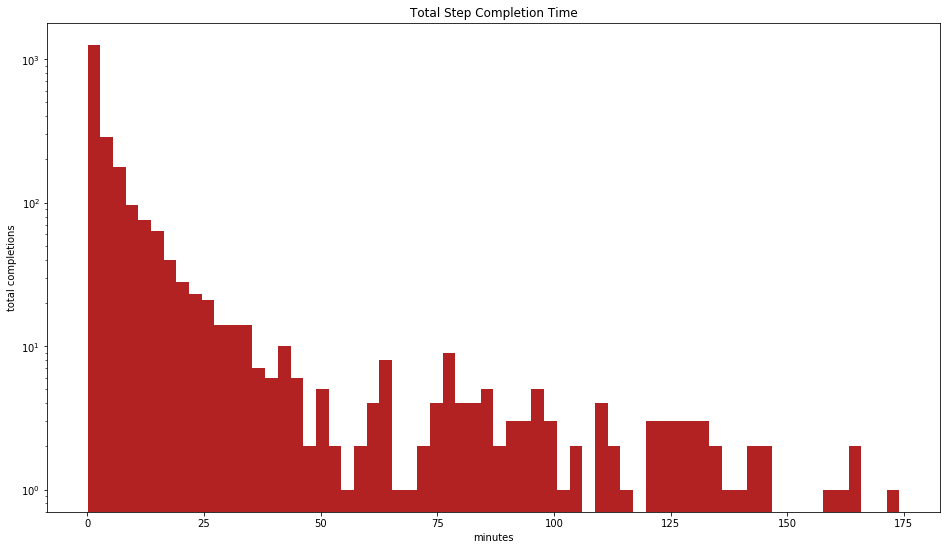

In [19]:
fig, ax = plt.subplots(figsize=(16, 9))
three_hours = 60*60*3
completed_time = step.completion_time[step.completion_time < three_hours]
ax.hist(completed_time / 60, bins=64, color='firebrick');
ax.set_yscale('log')
ax.set(title='Total Step Completion Time', xlabel='minutes', ylabel='total completions');

**Figure 1: Distribution of log step-time.**
We see the distribution of the time it took to complete any step of the course.
All steps are bundled together and the vertical scale is logarithmic,
which allows us to visualize both the small and large times.
There is a hard cutoff at $180$ minutes (three hours),
after which we consider the participant to have forgotten about the step.

Originally we have expected a Gaussian distribution for the completion times,
with a well defined peak around the common completion times (a few minutes perhaps).
Yet, we get a Poisson distribution suggesting either that most participants
would rush through the steps or would complete the steps fast at first
and only then come back to go through the step slowly.

The above was a generalization for all steps together.
If we build such a graph for every single step separately
we may be able to identify more interesting and less interesting steps
based on the time spent on them.

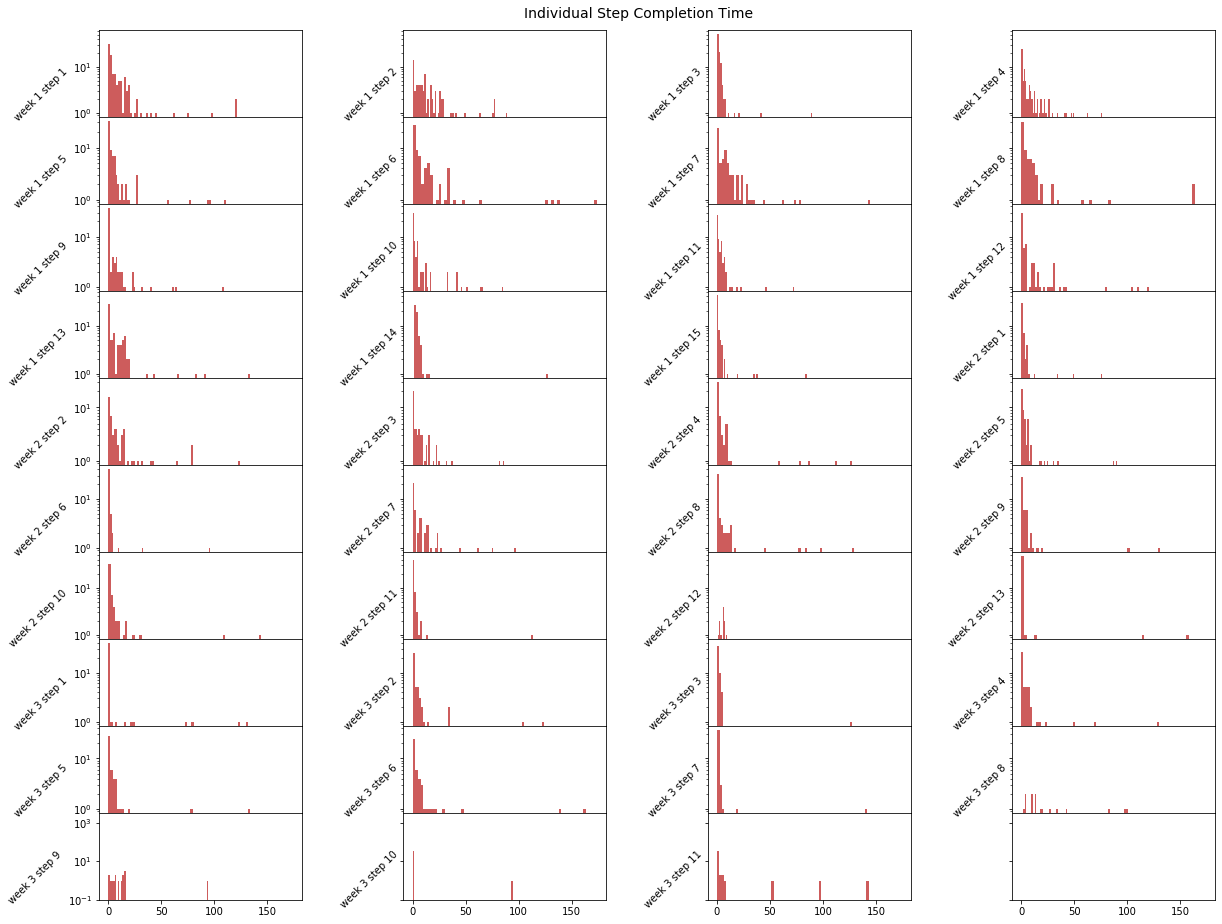

In [20]:
all_steps = dict([(k,v) for k,v in step.groupby(['week', 'step'])])
three_hours = 60*60*3
fig, ax = plt.subplots(int(np.ceil(len(all_steps)/4)), 4, sharex=True, sharey='row', figsize=(20, 16))
for i, s in enumerate(all_steps):
    (weeknum, stepnum) = s
    cur_step = all_steps[s]
    this_step = cur_step.completion_time[cur_step.completion_time < three_hours]
    ax.flat[i].hist(this_step / 60, bins=64, color='indianred')
    ax.flat[i].set_ylabel(f'week {weeknum} step {stepnum}', rotation=45, ha='right')
    ax.flat[i].set_yscale('log')
    x1, x2, y1, y2 = ax.flat[i].axis()

# fix last row ticks (avoid a matplotlib bug with empty plots)
ymin, ymax = ax.flat[-1].get_ylim()
ax.flat[-1].set_ylim(max(ymin, 0.1), min(len(step), ymax))
fig.suptitle('Individual Step Completion Time', y=.9, fontsize=14)
plt.subplots_adjust(wspace=0.5, hspace=0)

**Figure 2: Distribution of times per step.**
The same log step-time is plotted divided by the course steps.
Each steps is given its own distribution of completion times by participants.

The most interesting steps should have a more spread distribution.
One can argue that - statistically - the steps where people stopped a while to think
indicate that something sparkled interest.
Note that as the steps progress some participants will give up,
hence the statistical value decreases as the steps progress.
Also note that the last few rows of graphs are scaled lower than the rest,
this is both to avoid statistical conclusions from comparing top graphs
(in which many more people participated) with bottom graphs.
On top of that this scaling of later rows allow us to extend the code to as many steps
as possible in the data, whilst avoiding a known bug in `matplotlib`
that would make the last row out of scale if an empty graph was present.

Nevertheless, to compare the people who gave up during the course
and not participated in later steps we can attempt a different graph.
Since most people give up between weeks of a course,
we will plot the completion times by week and color differently
the participants that followed the course to the next week.

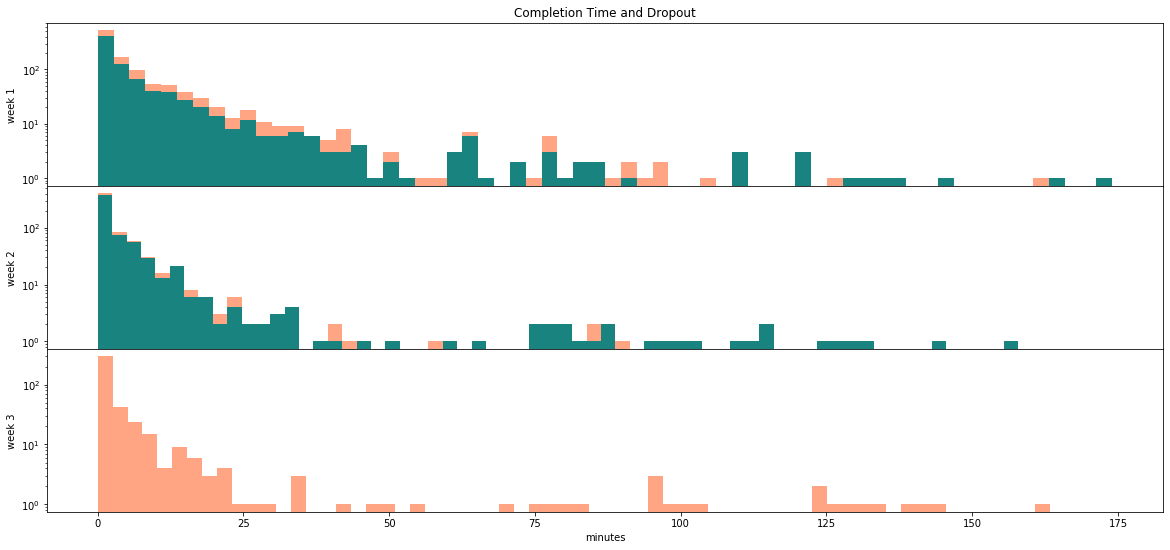

In [21]:
def plot_hist(step, week, ax):
    cur_step = step[step.week == week]
    next_step = step[step.week == week + 1][['participant_id', 'step']]
    if len(next_step):  # hardened code, the condition is not needed but just in case
        next_step = next_step.groupby('participant_id').count()
        next_step.columns = ['stayed']
        next_step['stayed'] = True
        next_step = next_step.reset_index()
        combined = pd.merge(cur_step, next_step, on='participant_id', how='left')
        combined['stayed'].fillna(False, inplace=True)
    else:
        combined = cur_step.copy()
        combined['stayed'] = False

    ctime = combined.completion_time
    three_hours = 60*60*3
    ctime = ctime[ctime < three_hours]
    _, bins, _ = ax.hist(ctime / 60, bins=64, color='coral', alpha=.7)

    stayed = combined[combined.stayed]
    if len(stayed):  # again not needed, but leave it hardened just in case
        ctime = stayed.completion_time
        ctime = ctime[ctime < three_hours]
        _, bins, _ = ax.hist(ctime / 60, bins=bins, color='teal', alpha=.9)

    ax.set_ylabel(f'week {week}')
    ax.set_yscale('log')

n = step.week.max()
fig, ax = plt.subplots(n, 1, sharex=True, figsize=(20, 3*n))
for i in range(n):
    plot_hist(step, i+1, ax.flat[i])

ax.flat[-1].set_xlabel('minutes')
ax.flat[0].set_title('Completion Time and Dropout')
plt.subplots_adjust(hspace=0)

**Figure 3: Log step-time distribution by week.**
In orange we see the participants that gave up that week
(in the last week all participants give up as it is the end of the MOOC).
In green we see the participants that stayed for the following week.
Note the vertical logarithmic scale,
the higher on the graph a difference between orange and green is present
the more participants gave up.

Each week (each graph) we see how many participants have completed the assigned
steps within a certain number of minutes.
Each week less and less participants complete the steps as participants give up the MOOC.
Participants that spend little time on the step are more likely to give
up and not follow the next week.
The left hand side where the completion times are small decreases fast,
whilst the right hand side remains reasonably constant.

From all three graphs,
a viable hypothesis is that at the very beginning participants spend time
on the steps out of curiosity, later the time spent is likely proportional
to the engagement of a step/session.  Notably, steps $3.7$, $3.8$ and $3.9$
appear to be quite engaging.

As for participants giving up, we can plot only that instead.

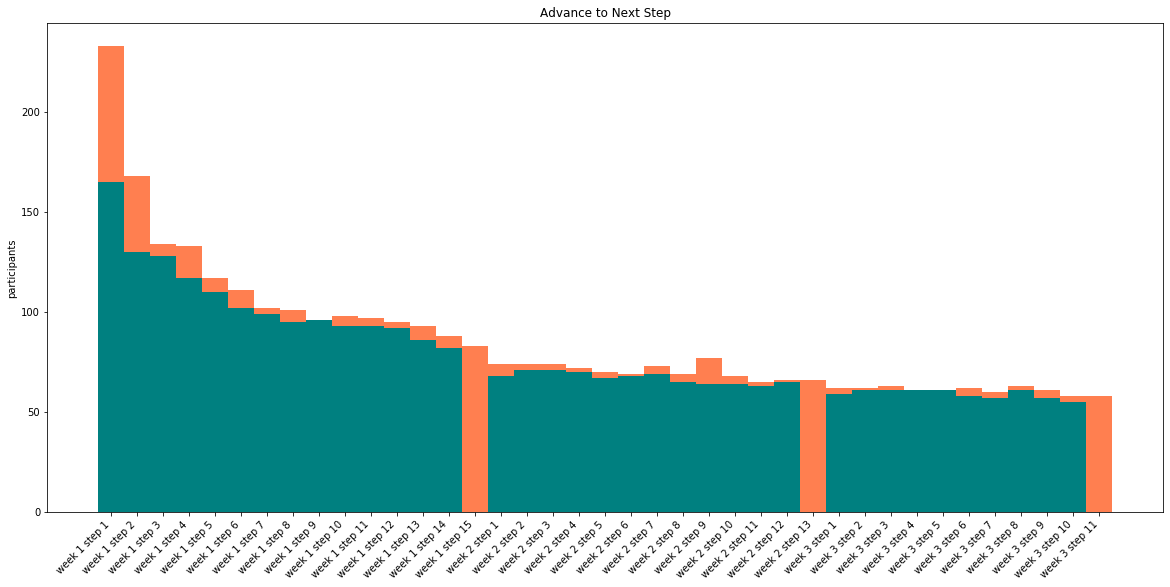

In [22]:
this_step = step[['participant_id', 'week', 'step', 'started']]
next_step = this_step.copy()
next_step.step -= 1
next_step.rename(columns={'started': 'advanced'}, inplace=True)
advanced = pd.merge(this_step, next_step, on=['participant_id', 'week', 'step'], how='left')
advanced['advanced'].fillna(False, inplace=True)
bars = advanced.groupby(['week', 'step']).sum()

fig, ax = plt.subplots(figsize=(20, 9))
ax.bar(range(len(bars)), bars.started.values, color='coral', width=1)
ax.bar(range(len(bars)), bars.advanced.values, color='teal', width=1)
ax.set_xticks(range(len(bars)))
labels = [f'week {i} step {j}' for i, j in bars.index]
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('participants')
ax.set_title('Advance to Next Step');

**Figure 4: Participant Advance to the Next Step.**
The orange bars report how many participants started a (current) step,
whilst the green bars report how many participants started the current
step and also started the next step.
The difference between the green and orange bars is how many participants
did not advance directly to the next step;
remember that the orange bars are *behind* the green bars.
In the last step of each week we do not plot a green bar,
which allows us to see the week splits.

Most differences between orange and green bars will be participants
that gave up on the course on the given step.
Albeit the differences may result from different cases too,
for example a participant that jumps over a step will be plotted
as orange in the previous step whilst he/she will continue to be
reported as green in the following step.
In the current data we can see a large number of participants giving
up early in the course but then the remainder of participants did
keep up with the course.

### Participant Confidence Responses

Next we will look at the responses to the confidence questions present
in the course questionnaires.
In order to allow the notebook to be used for different courses
one needs to explicitly state which week and step the questionnaires
of interest are present.

One assumption we make is that question $1$ in one questionnaire is
of similar spirit as question $1$ in the next questionnaire, and so on.
In other words, we assume that we can compare the same question numbers
across different questionnaires.

**CONFIGURATION NEEDED**.
The following variable must be set to the groupings of week and step
in which the questionnaires of our interest are.
It must be a list of tuples (or equivalent) in the format `(week_number, step_number)`.
For example, `confidence = [(1, 3), (2, 6)]` tells us that the questionnaires of
interest are in week 1 step 3 and week 2 step 6.
There is no limitation as to how many questionnaires can be added or
that there must be a questionnaire per week.
As many questionnaires with any combination of week can be added.
A chronological order is not needed but recommended
as the graphs below assume chronological order.

In [23]:
# this is week 1 step 3, week 2 step 6 and week 3 step 7
confidence = [(1, 3), (2, 6), (3, 7)]

We then build a data structure based on the configuration provided.
Note that we do *not* fully sanity check the configuration,
it may happen that the following works without error and the graphs
below become empty.
If that happens the most likely cause is the incorrect setting
of the variable above.

The sanity check below shall capture most (but not all) such issues.
The following shall not error and shall print the number of question
responses per questionnaire.
If any of the numbers is $0$ (zero) then either a misconfiguration
happened and/or it points to an empty questionnaire.
The check will not catch questionnaires with only some questions missing.

In [24]:
all_steps = []
for w, s in confidence:
    all_steps.append(response[(response.week == w) & (response.step == s)])
list(map(len, all_steps))

[416, 103, 175]

A questionnaire can be composed from several questions,
next we plot the questionnaires against questions
and build a histogram distribution of answers to each.

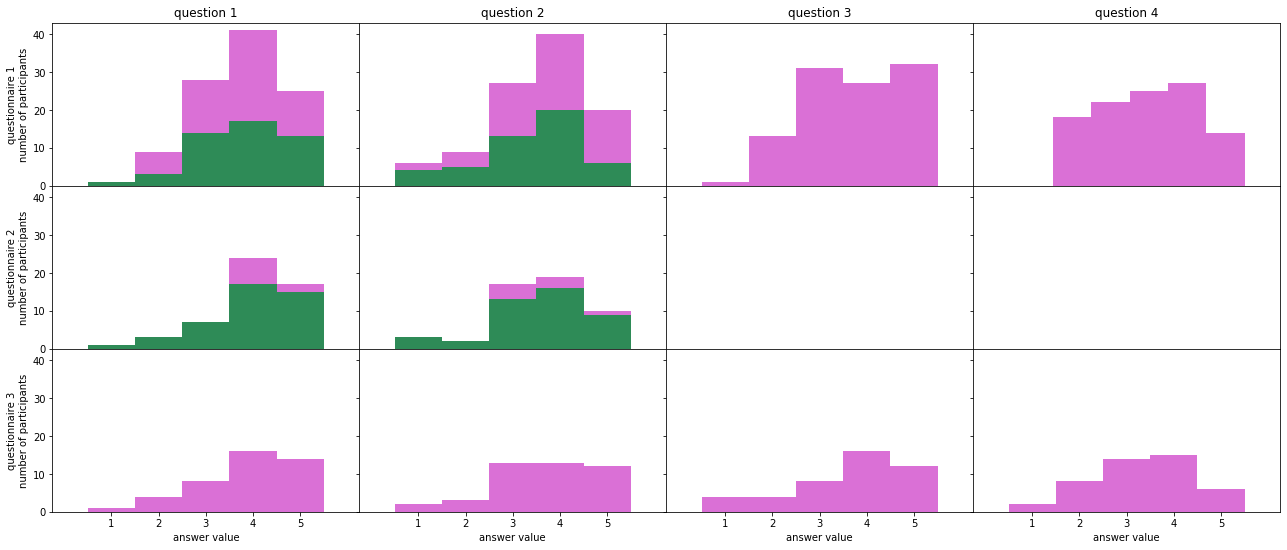

In [25]:
bins = int(response.response.max())
n_steps = len(all_steps)
n_questions = max(map(lambda x: len(x.question.unique()), all_steps))
fig, axs = plt.subplots(n_steps, n_questions, sharex=True, sharey=True, figsize=(22, n_steps*3))

for i in range(n_steps):
    for j in range(n_questions):
        this_step = all_steps[i]
        this_step = this_step[this_step.question == j + 1]
        next_step = all_steps[i+1] if i+1 < len(all_steps) else None
        ax = axs[i, j]
        _, edges, _ = ax.hist(this_step.response, bins=bins, color='orchid')
        if next_step is not None:
            next_step = next_step[['participant_id', 'question']]
            next_step = next_step[next_step.question == j + 1].copy()
            next_step.rename(columns={'question': 'next_week_question'}, inplace=True)
            qtmp = pd.merge(this_step, next_step, on='participant_id', how='inner')
            ax.hist(qtmp.response, bins=bins, color='seagreen')
        if j == 0:
            ax.set_ylabel(f'questionnaire {i+1}\nnumber of participants')
        if i == 0:
            ax.set_title(f'question {j+1}')
        if i+1 == n_steps:
            middles = (edges[:-1] + edges[1:]) / 2
            ticks = np.array(list(range(bins))) + 1
            ax.set_xticks(middles)
            ax.set_xticklabels(ticks)
            ax.set_xlim(middles[0]-1, middles[-1]+1)
            ax.set_xlabel(f'answer value')

plt.subplots_adjust(hspace=0, wspace=0)

**Figure 5: Distributions of Answers Across Questionnaires.**
The higher the answer value the higher is the confidence of the participant in that area.
The difference between colors again shows how many participants gave up on that week,
in this case we take a participant that gave up by checking if he/she has answered
the same question on the following questionnaire.
The scales between all graphs are the same,
the height can be compared to account for the change in confidence.

From the current data,
a fair hypothesis is to say that the positive change in confidence happens at the end of the MOOC.
Participants who did stay only for the beginning do not show a change in confidence.
But the participants that stayed to the end show a shift to the right in several places
between the graphs.
Note that a change in confidence if the difference between a previous graph (above from current)
in green to the next graph (current) in indigo.

### Participant Statistics

Until now all statistics have been generalized across all participants,
yet we have information that allows us to divide the participants into groups.
Groups by age, profession, education, whatnot;
Then we can build temporal graphs for the questionnaires on each group.

In order to automate the graphing we will build a data structure
for question answers similar to the one used in the previous graph,
but this time we will also build a structure for the participants
that did advance in the course.
Advanced to the next questionnaire, and the ones who
advanced through the complete course.

In [26]:
# We could loop only once for everything,
# but that would assume that we always have only a single step of interest per week.
# Looping several times allow for less assumptions on the data.
all_resp = []
all_resp_adv = []
all_resp_comp = []
for w, s in confidence:
    all_resp.append(response[(response.week == w) & (response.step == s)])

And since we are building the data structures we will construct
an analogous structure for the started steps by the participants.

In [27]:
all_step = []
all_step_adv = []
for w in range(step.week.max()):
    all_step.append(step[step.week == w+1])

Once the structures are built we will join the tables with the participant
table which will allow us to filter by the statistics we may want.

Note that this is all dependent on the setting of confidence configuration
a few steps above.

In [28]:
def enrich_data(step_resp):
    enriched = pd.merge(participant, step_resp, left_index=True, right_on='participant_id', how='right')
    # sanity check
    if len(step_resp) != len(enriched):
        print('WARNING: incomplete RIGHT join')
    return enriched

We have all the building blocks and we run them all together.
Once again remember the order of the notebook,
the code below is heavily dependent on the code cells above.

A few sanity checks are printed but these will not catch all possible issues,
notably problems with the confidence variable of weeks and steps where
the questionnaires are located.
If something goes wrong here,
the first place to check is the configuration a few steps back.

We build and enrich the responses structure.

In [29]:
first_resp = all_resp[0]
first_resp = first_resp[['participant_id', 'question', 'response']].copy()
first_resp.rename(columns={'response': 'first_response'}, inplace=True)
last_resp = all_resp[-1]
last_resp = last_resp[['participant_id', 'question', 'response']].copy()
last_resp.rename(columns={'response': 'last_response'}, inplace=True)
for i in range(len(all_resp)):
    this_resp = all_resp[i]
    next_resp = all_resp[i+1] if i+1 < len(all_resp) else None
    if next_resp is not None:
        # this grouping here is the main reason why we split into lists
        next_resp = next_resp[['participant_id', 'question', 'response']].copy()
        next_resp.rename(columns={'response': 'next_response'}, inplace=True)
        adv_step = pd.merge(this_resp, next_resp, on=['participant_id', 'question'], how='inner')
        adv_step['increase'] = adv_step.next_response - adv_step.response
        all_resp_adv.append(adv_step)
    else:
        # last element will always be empty
        df = this_resp.drop(this_resp.index)
        df['next_response'] = np.nan
        df['increase'] = .0
        all_resp_adv.append(df)
    comp_resp = pd.merge(this_resp, first_resp, on=['participant_id', 'question'], how='inner')
    comp_resp = pd.merge(comp_resp, last_resp, on=['participant_id', 'question'], how='inner')
    comp_resp['total_increase'] = comp_resp.last_response - comp_resp.first_response
    all_resp_comp.append(comp_resp)

all_resp = list(map(enrich_data, all_resp))
all_resp_adv = list(map(enrich_data, all_resp_adv))
all_resp_comp = list(map(enrich_data, all_resp_comp))
# sanity check
print('We got', len(all_resp_adv), 'questionnaires of interest')
print('And we got', len(all_resp_comp), 'questionnaires with completions')

We got 3 questionnaires of interest
And we got 3 questionnaires with completions


And build the analogous code for the started steps.

In [30]:
for i in range(len(all_step)):
    this_step = all_step[i]
    next_step = all_step[i+1] if i+1 < len(all_step) else None
    if next_step is not None:
        next_step = next_step[['participant_id', 'started']].copy()
        next_step = next_step.groupby('participant_id').sum().reset_index()
        next_step.rename(columns={'started': 'started_next'}, inplace=True)
        all_step_adv.append(pd.merge(this_step, next_step, on='participant_id', how='inner'))
    else:
        # last element will always be empty
        df = this_step.drop(this_step.index)
        df['started_next'] = False
        all_step_adv.append(df)

all_step = list(map(enrich_data, all_step))
all_step_adv = list(map(enrich_data, all_step_adv))
# sanity check
print('And we got', len(all_step_adv), 'weeks in the course')

And we got 3 weeks in the course


### Violin Graph

In order to display and compare distributions in time we will use groups of violin graphs.
A violin graph displays two probability distributions on each side of a vertical divide,
Each distribution follows a probability hence the area under each distribution is always the same,
this means that once can **compare the shape of the distribution but cannot compare the total height**.

Several graphic libraries have violin graph engines but these engines can be unstable,
at the time of writing all graph engines with extensive violin graph options are either
in alpha or beta stages of development and can change their APIs without warning.
To make the code as long lived as possible we write our own (tiny) violin graph engine
on top of the basic violin graph functionality in the stable `matplotlib` library.
The following code builds violin graphs.

In [31]:
def half_violin(x, y, *args, ax=None, left=False, mean=None, meadian=None, color=None, alpha=None, **kwargs):
    # force a clean plot so we can add these manualy
    kwargs['showmeans'] = False
    kwargs['showextrema'] = False
    kwargs['showmedians'] = False
    # allow for lists and single values
    if type(alpha) is not list and type(alpha) is not tuple and type(alpha) is not np.ndarray:
        alpha = [alpha]*len(x)
    if type(color) is not list and type(color) is not tuple and type(color) is not np.ndarray:
        color = [color]*len(x)
    # filters out empty arrays (sanity check first)
    filtered = zip(*[(x, y, c, a) for x, y, c, a in zip(x, y, color, alpha) if len(x) > 0])
    if not list(filtered):  # everything is empty, bail
        return
    x, y, color, alpha = zip(*[(x, y, c, a) for x, y, c, a in zip(x, y, color, alpha) if len(x) > 0])
    params = ax.violinplot(x, y, *args, **kwargs)
    for i, b in enumerate(params['bodies']):
        if not b.get_paths():  # empty graph - violinplots do not work well with missing data
            continue
        # get the center
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        clips = [m, np.inf]
        if left:
            clips = [-np.inf, m]
        # modify the paths to not go further right than the center
        b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], *clips)
        if color[i]:
            b.set_color(color[i]) 
        if alpha[i]:
            b.set_alpha(alpha[i])


def double_violin(xl, xr, y, *args, ax=None, color_left=None, color_right=None, **kwargs):
    half_violin(xl, y, *args, ax=ax, left=True, color=color_left, **kwargs)
    half_violin(xr, y, *args, ax=ax, color=color_right, **kwargs)

The question versus questionnaire graph - similar to the previous
one above - will allow us to understand how to read a group of
violin graphs in time.
We will call one side of the violin (a distribution) a half-violin
and a double sided violin (two distributions) a double-violin.
(Please ignore the mathematical inconsistency of these names.)

The first double-violin contains the distribution for the first questionnaire,
from which the left half-violin is the distribution of all answers from all
participants whilst the right half-violin is the distribution of answers
of the participants which advanced to the following step/questionnaire.
The next double-violin contains the answers for the next questionnaire,
again, all of them on the left and the part that advanced on the right.
Hence the complete graph can be read left to right:
all answers for first questionnaire versus answers to the first
by participants that did answer the second,
then the second questionnaire's all answers on the left of second
double-violin and so on.
Note that the answers to the first questionnaire by participants that answered
the second questionnaire are a different set of answers than the answers to
the second questionnaire.  i.e. the right half-violin of the previous double-violin
and the left half-violin of the current double-violin has the same participants
answering but it has their answers at two different points in time.

In order to see statistical significance across half-violins distributed from
a different number of data points we add transparency based on the amount of data.
The colors are more opaque (brighter in a white background) as more data is used.
For the case of a MOOC, where people give up as the course progresses,
we see more and more transparent violins as we go right (forward chronologically).

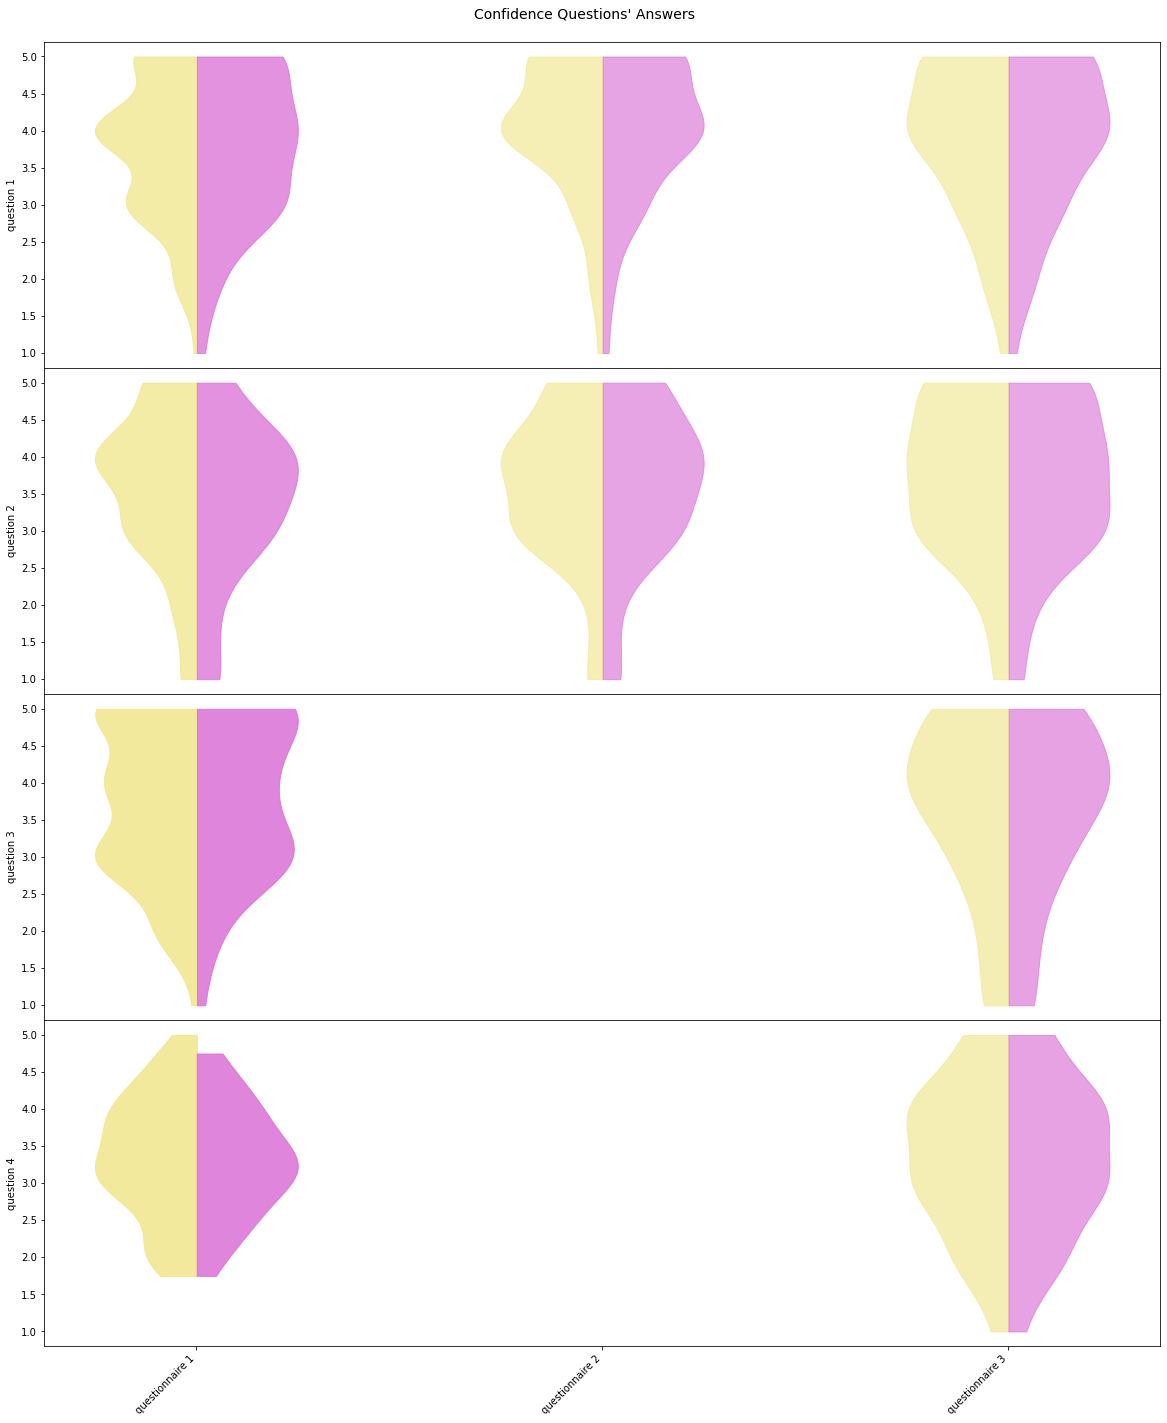

In [32]:
n_questions = max(map(lambda x: len(x.question.unique()), all_resp))
fig, ax = plt.subplots(n_questions, 1, sharex=True, figsize=(20, 6*n_questions))

ticks = list(range(len(all_resp)))
labels = list(map(lambda x: f'questionnaire {x+1}', ticks))
for i in range(n_questions):
    fil = lambda x: x[x.question == i+1].response.dropna().reset_index(drop=True)
    left = list(map(fil, all_resp))
    right = list(map(fil, all_resp_comp))
    atmp = np.array(list(map(len, left)))
    alpha = atmp / (atmp.sum() * 2) + .5  # weight size for alpha values
    double_violin(left, right, ticks, ax=ax[i], color_left='khaki', color_right='orchid', alpha=alpha)
    ax[i].set_ylabel(f'question {i+1}')

ax[-1].set_xticks(ticks)
ax[-1].set_xticklabels(labels, rotation=45, ha='right')
fig.suptitle("Confidence Questions' Answers", y=.9, fontsize=14)
plt.subplots_adjust(hspace=0)

**Figure 6: Violin graphs for Questionnaire Answers to each Question.**
We see similar distributions as in the previous graphs but the violin
graphs are probabilistic distributions as opposed to the previous raw histograms.
Where before missing questions from questionnaires appeared as empty graphs
here the missing questions appear as missing half-violins.
Note that the last half-violin will always be a half as there is no
next week/questionnaire to advance to.

From the current data we see the same general trend towards upper answers
as we saw in the raw histograms.
Remember that the violin graphs allow us to inspect the distribution shape
with more precision than raw histograms but the height of the distribution
is meaningless when compared because all distributions have the same area.
The total amount of data points is shown by the brightness of the color,
by the opaqueness, where less data makes for transparent (bleak) graphs.

### Generalized Statistics

The main reason for the violin graphs is that we can split the data across
statistics of participants and plot a set of violins for each split.
We can take any column from the participant table of the data model.

In [33]:
participant.columns

Index(['enrolled_at', 'unenrolled_at', 'role', 'fully_participated_at',
       'purchased_statement_at', 'gender', 'country', 'age_range',
       'highest_education_level', 'employment_status', 'employment_area',
       'detected_country', 'unlimited', 'id', 'responded_at', 'archetype',
       'total_comments', 'total_likes'],
      dtype='object')

Let us take any of the participant statistics and check the values.
We can do this with `value_counts`.

In [34]:
participant['highest_education_level'].value_counts()

Unknown                 330
university_degree        28
university_masters       15
tertiary                  6
university_doctorate      4
secondary                 3
Name: highest_education_level, dtype: int64

Note that the list of values is always in decreasing order,
which also means a decreasing statistical value.
For each grouping in the statistic we can plot a set of violin plots
as we did before for all questionnaires.
We will do so in the decreasing order of statistical significance
and the graphs shall vanish as we go from left to right.

The graphs may become unreadable if there are too many groupings
hence we will make a default limit of a maximum of $13$ groupings.
The value is arbitrary and woks well for a standard screen size
(around $20$ inches wide) and $3$ questionnaires.
One can use the `limit=` parameter to adjust the limit as needed.
One can even say `limit=None` to remove the limit altogether and
plot all groupings even if they exceed $13$ groupings.

In [35]:
# to keep things readable, we limit by 13 biggest values by default
def plot_response(stat, dropouts=False, start=0, limit=13):
    n_questions = max(map(lambda x: len(x.question.unique()), all_resp))
    estat = participant[stat].value_counts()
    fig, ax = plt.subplots(n_questions, 1, sharex=True, figsize=(20, 6*n_questions))
    all_adv = all_resp_comp
    if dropouts:
        all_adv = all_resp_adv

    colors = [('khaki', 'orchid'), ('seagreen', 'firebrick')] * int(np.ceil(len(estat) / 2))
    ticks = list(range(len(all_resp)))
    complete_ticks = []
    labels = list(map(lambda x: f'questionnaire {x}', ticks))
    complete_labels = []
    walk = enumerate(estat.index)
    if limit:
        walk = list(walk)[start:limit]
    for n_stat, cur_stat in walk:
        max_respondents = np.array([0]*len(all_resp))
        for i in range(n_questions):
            fil = lambda x: x[(x.question == i+1) & (x[stat] == cur_stat)].response.reset_index(drop=True)
            left = list(map(fil, all_resp))
            right = list(map(fil, all_adv))
            # weight size for alpha values (prevent division by zero)
            atmp = np.array(list(map(len, left)))
            alpha = atmp / (atmp.sum() * 2 + .1) + .5
            cleft, cright = colors[n_stat]
            double_violin(left, right, ticks, ax=ax[i], color_left=cleft, color_right=cright, alpha=alpha)
            ax[i].set_ylabel(f'question {i+1}')
            max_respondents = list(map(lambda x: max(*x), zip(max_respondents, atmp)))
            #print(max_respondents)
        complete_ticks += ticks
        ticks = list(map(lambda x: x+n_questions+1, ticks))
        def mklabels(l):
            q, stat = l
            return f'{cur_stat} ({stat}/{estat[cur_stat]}) - ' + q
        complete_labels += list(map(mklabels, zip(labels, max_respondents)))

    ax[-1].set_xticks(complete_ticks);
    ax[-1].set_xticklabels(complete_labels, rotation=45, ha='right')
    fig.suptitle(stat, y=.9, fontsize=14)
    plt.subplots_adjust(hspace=0)
    return estat

We can now plot against whichever statistic we may wish with a simple function call.

Unknown                 330
university_degree        28
university_masters       15
tertiary                  6
university_doctorate      4
secondary                 3
Name: highest_education_level, dtype: int64

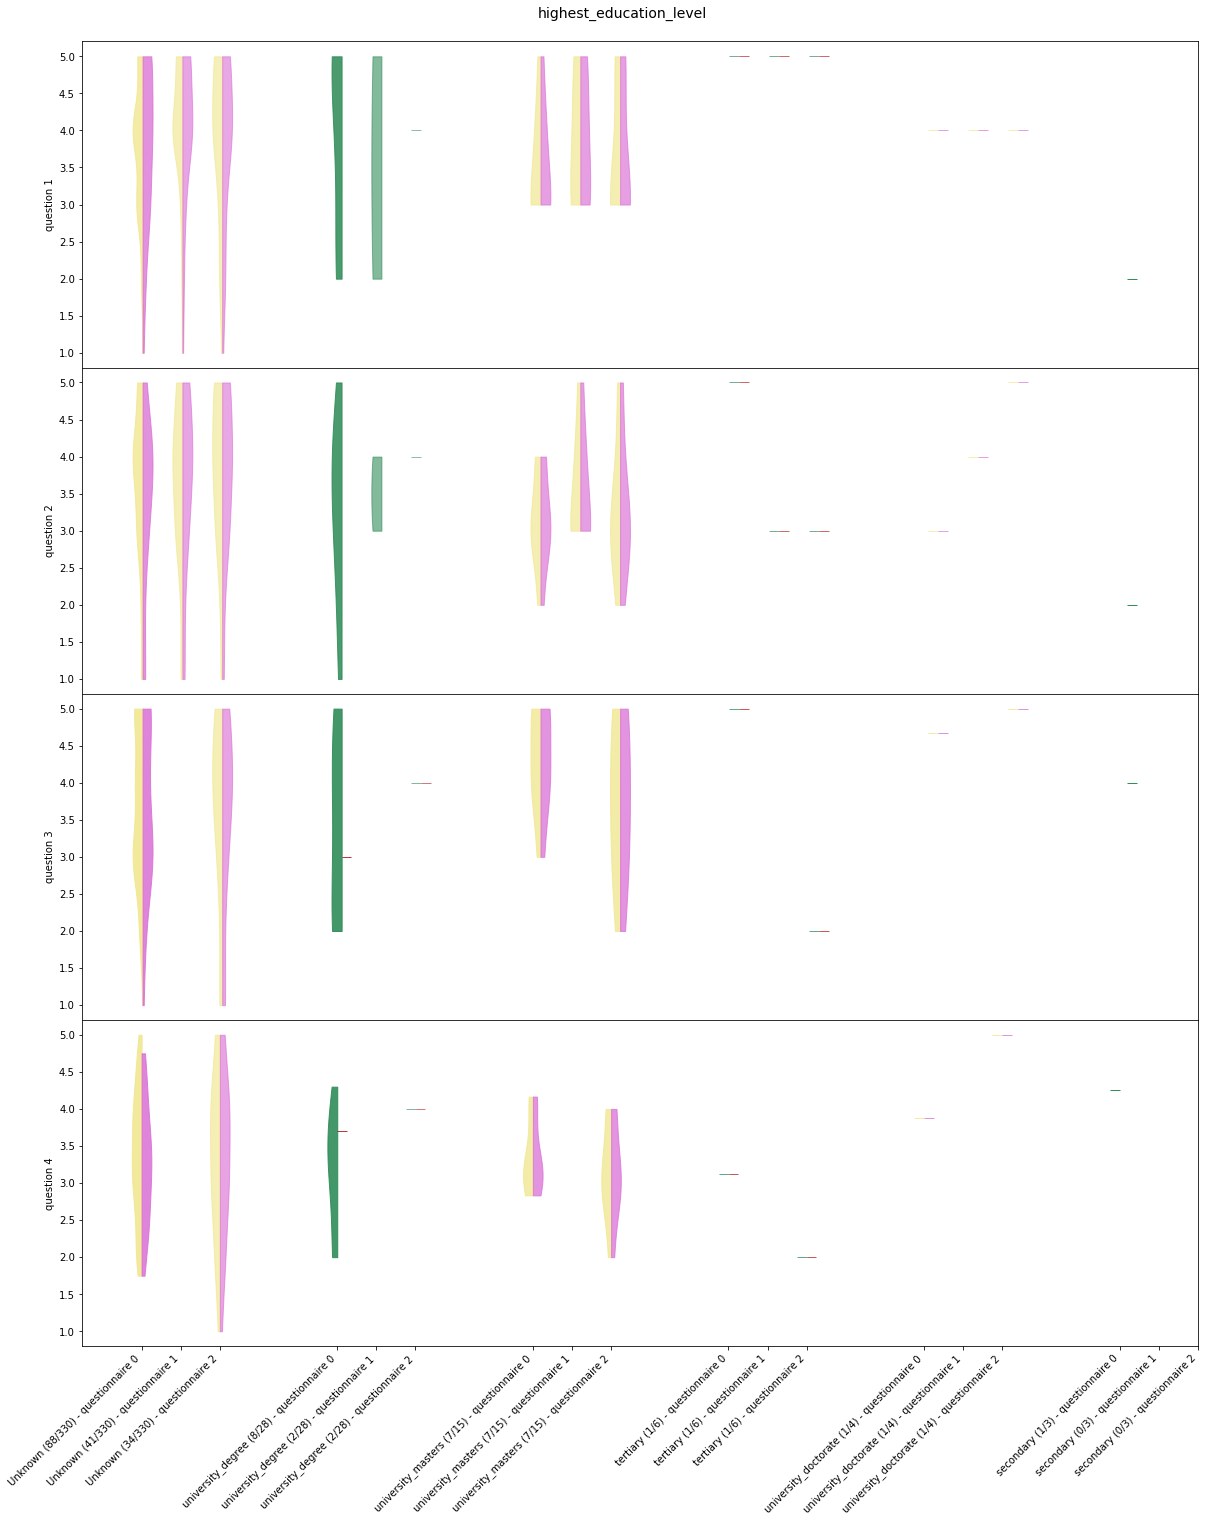

In [36]:
plot_response('highest_education_level')

**Figure 7: Violin Graphs for each Highest Education Level Grouping.**
The graphs use less and less statistically valuable groupings as we
read from left to right.
The transparency of the graphs indicates the statistical significance
within that grouping (amount of data used).
While the significance across groupings can be estimated from the bottom labels.
Each label contains the size of the *complete* grouping,
hence it is the amount of data used for the complete set of violin graphs.
Each violin graph set is separated by the color convention,
the sets alternate between yellow (khaki) left / pink (orchid) right
and green (sea green) left / orange (firebrick) right.

The function that generates the graph can be called with

    plot_response('statistic', dropouts=False, start=START_NUMBER, limit=LIMIT_NUMBER)

Where both `start=` and `limit=` are optional and `'statistic'` is a column from
the participant table - which must be placed in quotes.
On the left of the violins we plot all participants,
whilst on the right of the violin we plot the participants that kept on with
the course to the following weeks.
The `dropouts=` parameter, if set to a true value will include - in the right
half-violin - participants that continued the course for a while more but
then dropped out eventually from the course.
When `dropouts=False` (the default), the right half-violins include
only the participants that finished the MOOC.

Statistic groupings will be plotted in decreasing order,
the `start=` parameter is the number of groupings to ignore from the left.
Whilst the `limit=` is the grouping at which to stop plotting also from the left.
For example, to plot from the second grouping and plot $3$ groupings one would do:

    plot_response('higher_education_level', start=1, limit=4)

This plots the 2nd, 3rd and 4th groupings.
In the case of our data these are "university_degree", "university_masters" and "tertiary".
To plot just a single grouping one must set `start=` and `limit=` to adjacent numbers.
For example, to plot the grouping for "university_masters" in our data one would do:

    plot_response('higher_education_level', dropouts=False, start=2, limit=3)

The syntax for `start=` and `limit=` is zero based counting, borrowed from Python lists.
Let's try an example with a different statistic.

Unknown    329
GB          16
AU           6
NL           3
US           2
PH           2
FR           2
KE           2
EC           1
SA           1
OM           1
IQ           1
MY           1
CL           1
AT           1
IE           1
IN           1
RW           1
JP           1
CA           1
MM           1
ZM           1
NG           1
GE           1
PK           1
ML           1
LK           1
EG           1
MN           1
AF           1
TH           1
GH           1
Name: country, dtype: int64

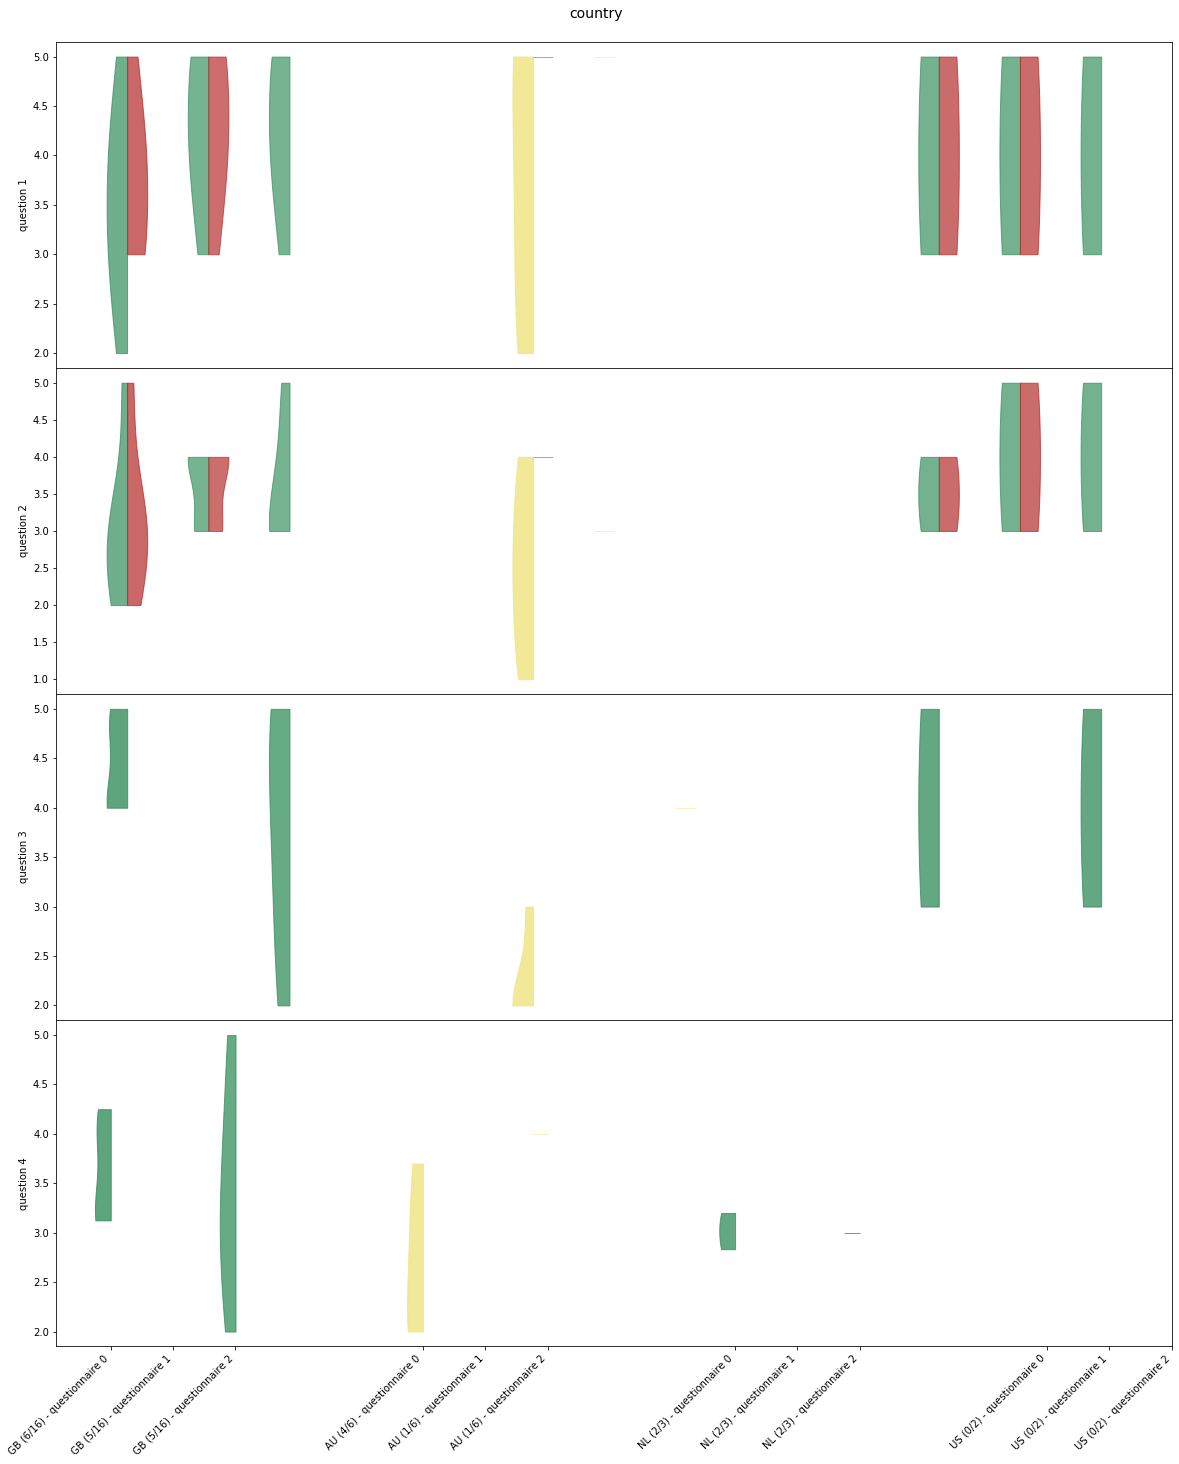

In [37]:
plot_response('country', dropouts=True, start=1, limit=5)

**Figure 8: Violin Graphs for Country Groupings.**
We can see a more varied number of trends,
some trends going up and some going down.
Yet, with the current data, the statistical significance can be often lacking.

### Generalized Statistics for Steps

Now that we have built a generalized statistics function call for plotting
participant table column groupings against participant responses
we can do the same against started MOOC steps.
We start with the general graph.

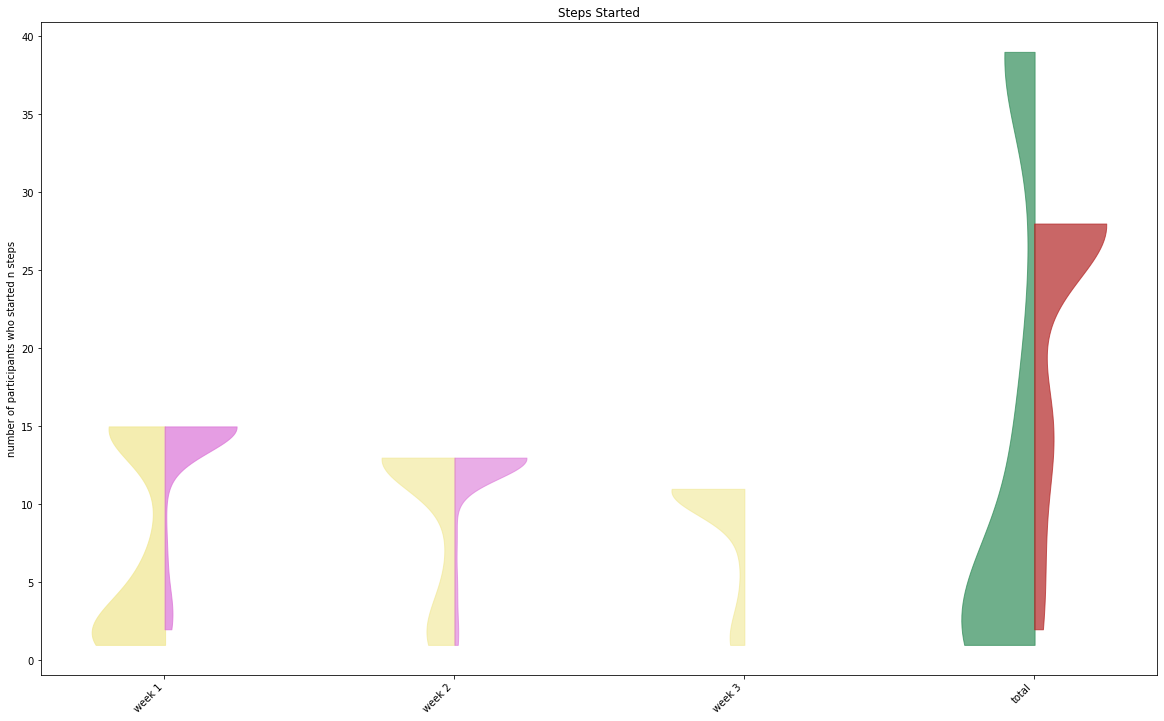

In [38]:
ticks = list(range(len(all_step)))
labels = list(map(lambda x: f'week {x+1}', ticks)) + ['total']
ticks += [len(all_step)]
colors_left = ['khaki'] * len(all_step) + ['seagreen']
colors_right = ['orchid'] * len(all_step) + ['firebrick']
all_group = all_step + [all_step[0].append(all_step[1:])]
all_group_adv = all_step_adv + [all_step_adv[0].append(all_step_adv[1:])]
fil = lambda x: x.groupby('participant_id').sum().started
left = list(map(fil, all_group))
right = list(map(fil, all_group_adv))
atmp = np.array(list(map(len, left)))
alpha = atmp / (atmp.sum() * 2) + .5  # weight size for alpha values

fig, ax = plt.subplots(figsize=(20, 12))
double_violin(left, right, ticks, ax=ax,
              color_left=colors_left, color_right=colors_right, alpha=alpha)
ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('number of participants who started n steps')
ax.set_title('Steps Started');

**Figure 9: Number of Total Started Steps across Weeks.**
Here we see two well known trends,
first, participants either give up early completing very few steps
or complete the majority of the steps for the week.
Second, we see that the majority of participants give up after a few steps in the first week.
Note that we have a graph for every week and then one graph for the grand total of steps.
The half-violins are read in the same way as with questionnaires:
the left half-violin is for all participants whilst the right one is
for the participants that advanced for the following week.

A new trend visible in this specific data is the set of participants that did
start the same step several times, many of these participants did not advance for the next week.
We can see this trend in the grand total double-violin where the left-half violin is higher.
The trend suggests that many participants may prefer to mix and match the MOOC steps
at their own pace rather than following the steps in order.

Next we build the generalized statistics graph function call as we do for responses.
For the steps we have week graphs and a grand total graph,
hence **we will plot a set of violin graphs for a single grouping in a vertical fashion.**
This is different from the graph just above.

In [39]:
# to keep things readable, we limit by 13 biggest values by default
def plot_step(stat, start=0, limit=13):
    total = all_step[0].append(all_step[1:])
    n_weeks = total.week.max()
    estat = participant[stat].value_counts()
    fig, ax = plt.subplots(n_weeks + 1, 1, sharex=True, figsize=(20, 6*n_weeks + 6))

    colors_left = (['khaki', 'seagreen'] * len(estat))[:len(estat)]
    colors_right = (['orchid', 'firebrick'] * len(estat))[:len(estat)]
    ticks = list(range(len(estat)))
    if limit:
        ticks = ticks[start:limit]
    ylabels = list(map(lambda x: f'week {x+1}', range(n_weeks))) + ['total']
    complete_ticks = []
    labels = estat.index
    if limit:
        labels = labels[start:limit]
    all_group = all_step + [all_step[0].append(all_step[1:])]
    all_group_adv = all_step_adv + [all_step_adv[0].append(all_step_adv[1:])]
    for i in range(n_weeks + 1):
        walk = enumerate(estat.index)
        if limit:
            walk = list(walk)[start:limit]
        left = []
        right = []
        for n_stat, cur_stat in walk:
            fil = lambda x: x[x[stat] == cur_stat].groupby('participant_id').sum().started
            left.append(fil(all_group[i]))
            right.append(fil(all_group_adv[i]))
        # weight size for alpha values (prevent division by zero)
        atmp = np.array(list(map(len, left)))
        alpha = atmp / (atmp.sum() * 2 + .1) + .5
        double_violin(left, right, ticks, ax=ax[i],
                      color_left=colors_left, color_right=colors_right, alpha=alpha)
        ax[i].set_ylabel(ylabels[i])

    ax[-1].set_xticks(ticks);
    ax[-1].set_xticklabels(labels, rotation=45, ha='right')
    fig.suptitle(f'Steps started by {stat}', y=.9, fontsize=14)
    plt.subplots_adjust(hspace=0)
    return estat

The call `plot_step` is analogous and has the same arguments and usage as `plot_response`.
This includes the `start=` and `limit=` optional arguments.

For example, using the groupings for education levels in the current data.

Unknown                 330
university_degree        28
university_masters       15
tertiary                  6
university_doctorate      4
secondary                 3
Name: highest_education_level, dtype: int64

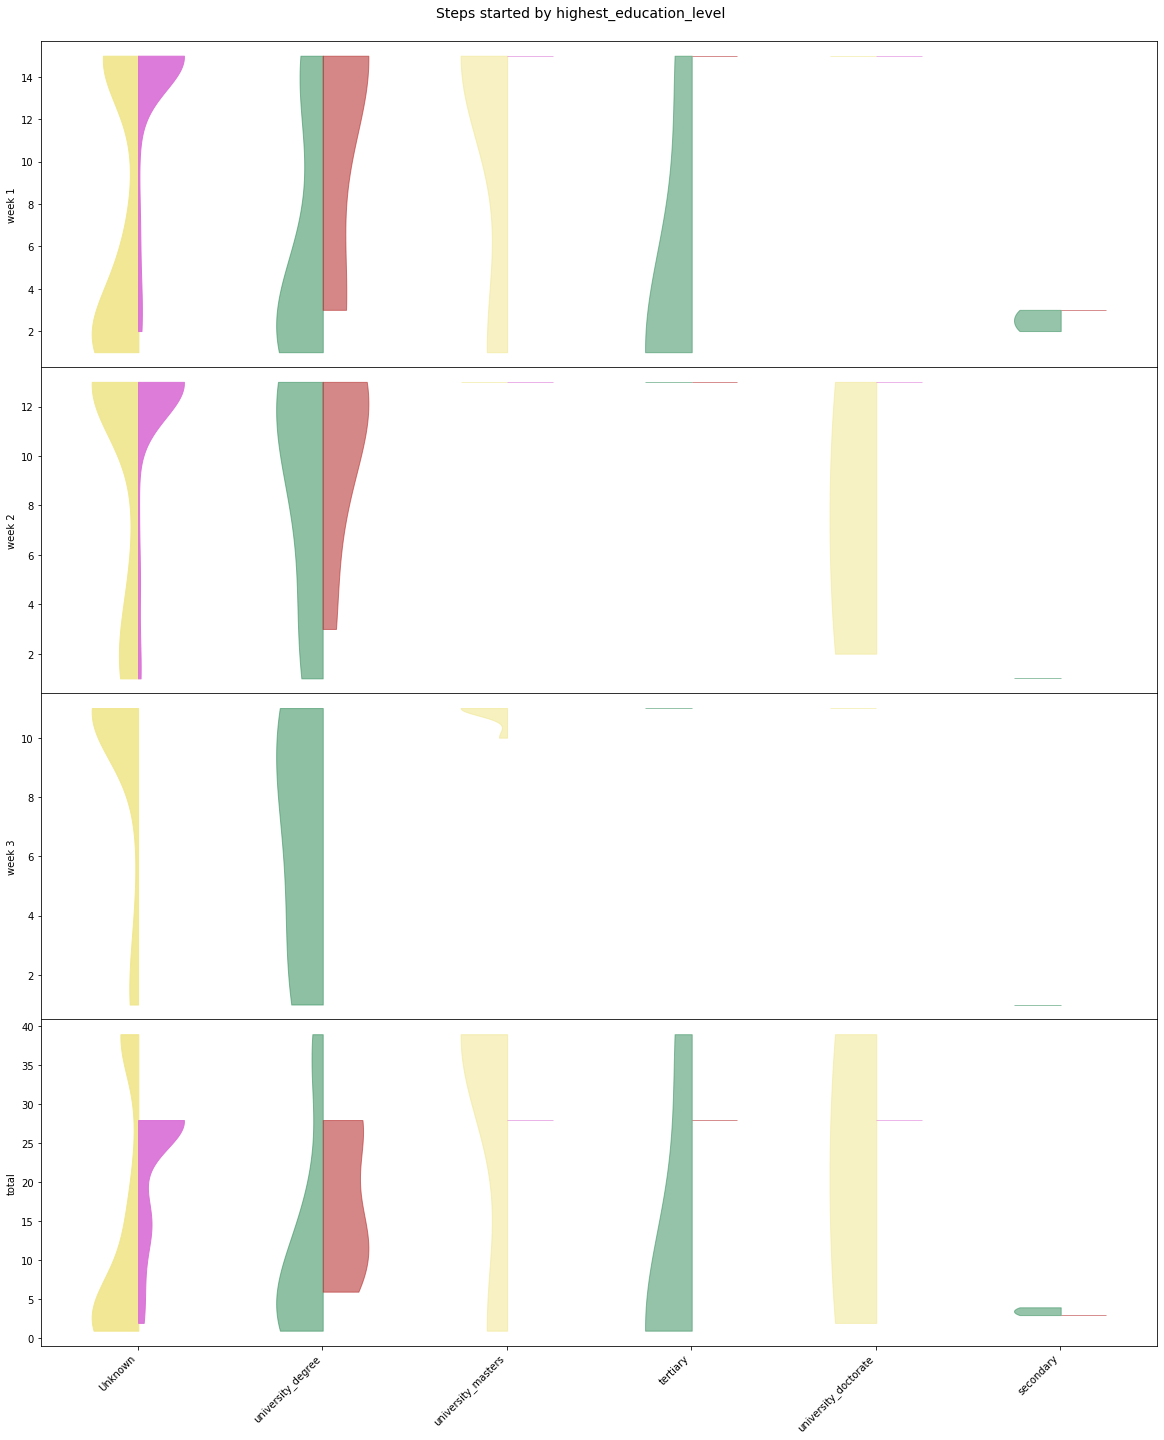

In [40]:
plot_step('highest_education_level')

**Figure 10: Started Steps for Highest Education Level Groupings.**
The horizontal axis contains several sets of violin graphs, one for each grouping.
Note that the graphs for the grand total are now in the last row of the joined graphs.

---

## Part 3: Extra Analysis

In this part we use the tools and extra data structures we have built above
to perform an analysis dependent on the dataset we currently use.
This analysis is very unlikely to generalize for datasets of a different source,
i.e. datasets that have different column names or just have no columns
at all for the statistics we display here.

For a start we can try a few more statistics on responses.

Unknown    335
26-35       20
36-45       11
18-25        8
46-55        4
56-65        4
>65          4
Name: age_range, dtype: int64

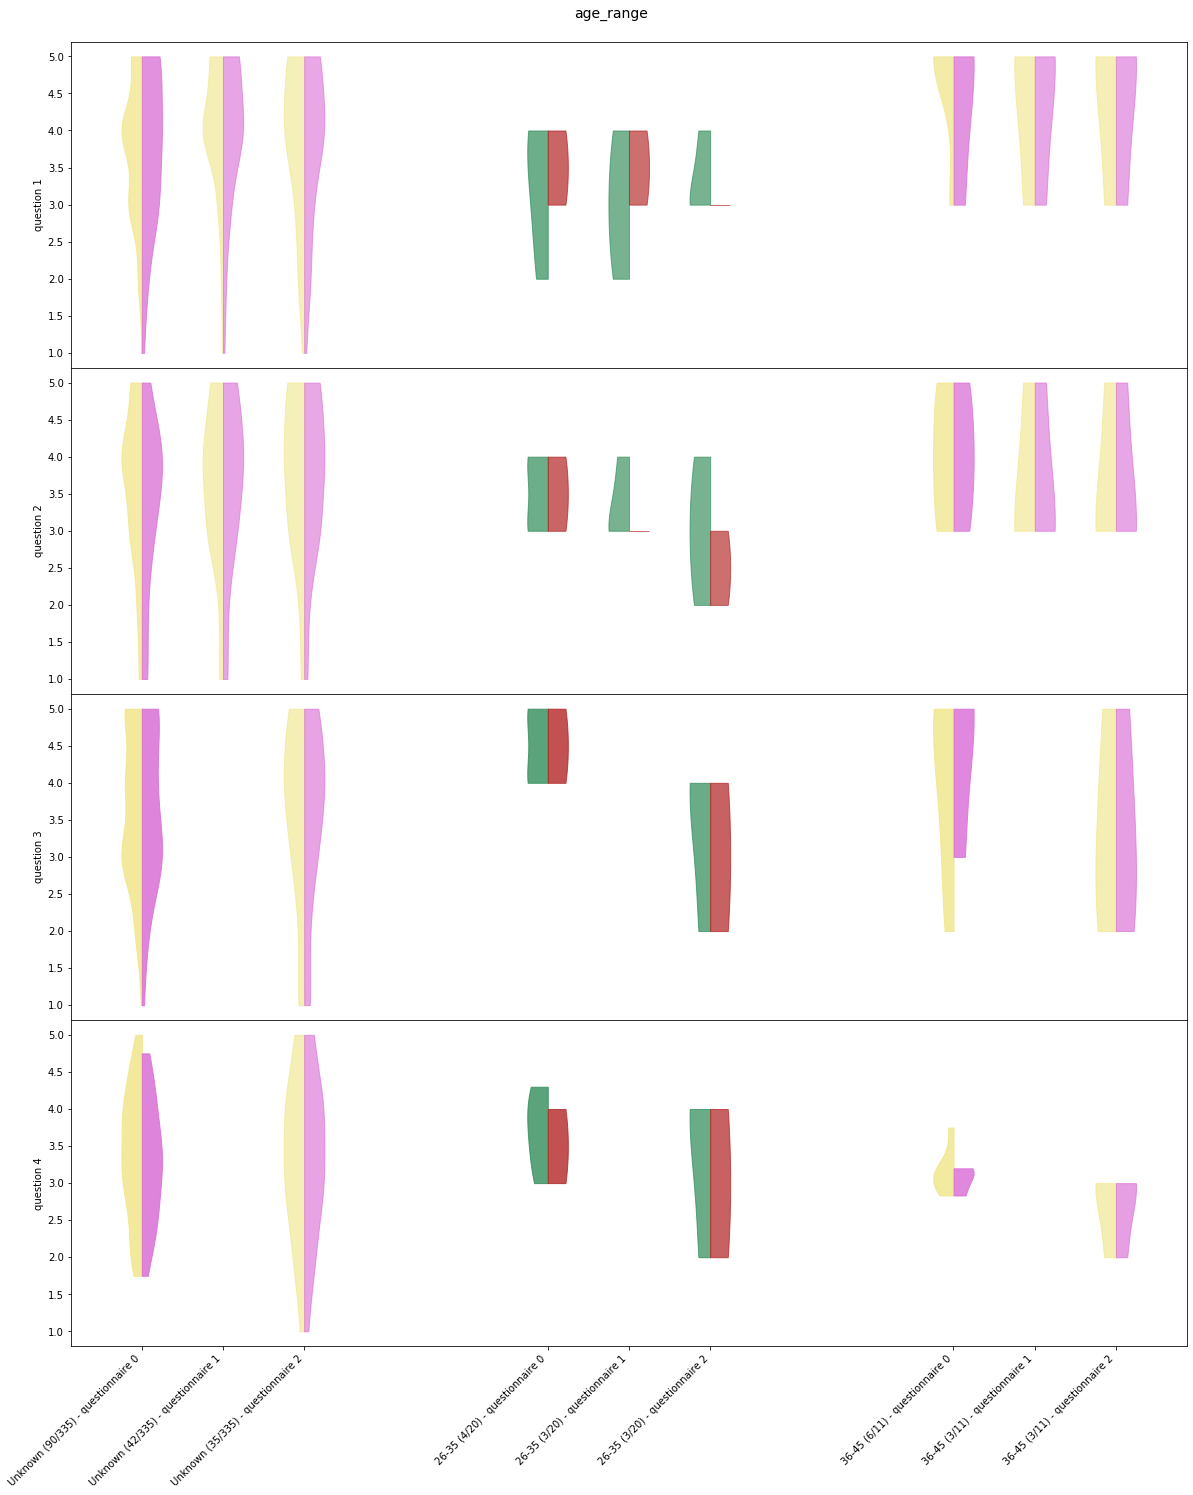

In [41]:
plot_response('age_range', limit=3)

**Figure 11: Questionnaire Answers on Age Groupings.**
Note that the groupings are ordered not by age but by the number
of participants in that age group.

And we can do an analogous analysis for the started steps.

Unknown    335
26-35       20
36-45       11
18-25        8
46-55        4
56-65        4
>65          4
Name: age_range, dtype: int64

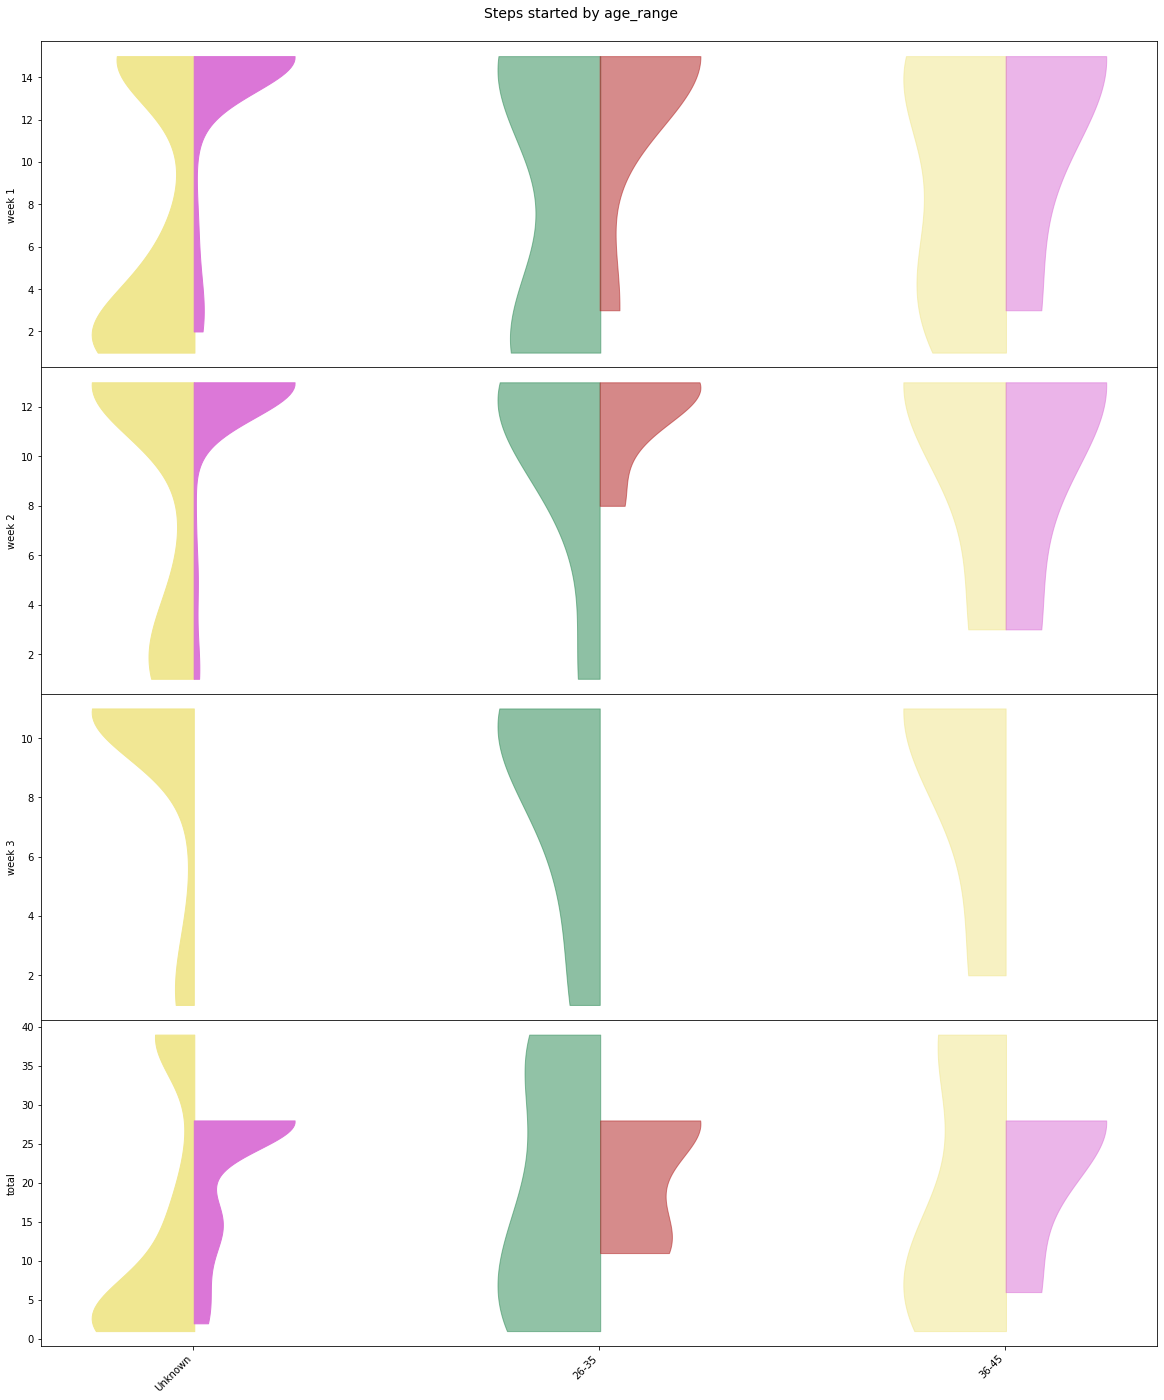

In [42]:
plot_step('age_range', limit=3)

**Figure 12: Started Steps on Age Groupings.**
Again, remember that the groupings are in order of the number of
participants in a given grouping.

For the current data the $26-35$ group is not very confident on the first two questions,
albeit the group is very diligent in following the course.
The $36-45$ group on the other hand is slightly less diligent but
considerably more confident.

## Comments

The extra data we have in this specific dataset are comments made by participants.
To display all comments would be the same as just reading the data files,
instead we will attempt to display the comments by the participants with
the higher confidence.
We can define a high confidence participant as one who either:

- Answered all the questions in the last questionnaire with a high confidence value,
- or, answered a question in a later questionnaire higher than in a previous questionnaire
  (i.e. his/her confidence has increased over the course of the MOOC).

From here on we will call these two groups of participants as "high confidence"
and "high confidence increase".
To find the participants with high confidence we take the top 9th quantile
(the to 10% if you prefer) of every question.
Since we are looking for comment we only consider participants that
did post comments.

In [43]:
high_confidence = all_resp[-1].response.quantile(.9)
conf = all_resp[-1][(all_resp[-1].response >= high_confidence) & (all_resp[-1].total_comments > 0)]
conf = conf.groupby(['participant_id', 'week', 'step']).first().sort_values(by='total_comments', ascending=False)
conf.reset_index(inplace=True)
conf = conf.set_index('participant_id').drop(columns=['week', 'step'])
print(f'{len(conf.index)} participants with high confidence')
conf

10 participants with high confidence


,enrolled_at,unenrolled_at,role,fully_participated_at,purchased_statement_at,gender,country,age_range,highest_education_level,employment_status,...,unlimited,id,responded_at,archetype,total_comments,total_likes,question,response,started,completed
participant_id,,,,,,,,,,,,,,,,,,,,,
fc5bdb5c-6626-41bd-af5b-9e94f953a93b,2021-06-03 20:55:38+00:00,NaN,NaN,2021-06-09 10:21:28+00:00,NaN,female,NL,36-45,university_masters,self_employed,...,t,17376002.0,2021-06-03 21:01:10+00:00,Vitalisers,26.0,2.0,1,5.0,True,True
5dbc5979-cada-4a1a-95c8-5cab8ecff9a5,2021-05-31 06:30:42+00:00,NaN,NaN,2021-06-05 13:32:13+00:00,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,...,f,17332033.0,2021-05-31 07:12:21+00:00,Hobbyists,10.0,3.0,2,5.0,True,True
b1d23730-cf2c-478b-9354-e7a06907a335,2021-04-27 19:27:04+00:00,NaN,NaN,2021-05-04 11:01:05+00:00,NaN,female,GB,36-45,tertiary,working_part_time,...,f,16963530.0,2021-04-27 19:42:08+00:00,Vitalisers,10.0,13.0,1,5.0,True,True
ca34b0f4-fb59-4a40-b1ca-f73ec6ee02b9,2021-05-05 05:26:04+00:00,NaN,NaN,2021-05-13 13:46:37+00:00,2021-06-08 11:41:59 UTC,Unknown,Unknown,Unknown,Unknown,Unknown,...,f,NaN,NaT,NaN,8.0,9.0,1,5.0,True,True
24509c4e-20f4-4a67-be61-c24de9b7e573,2021-04-01 14:54:24+00:00,NaN,NaN,2021-05-13 14:17:40+00:00,NaN,male,GB,56-65,university_masters,looking_for_work,...,t,16655598.0,2021-04-01 15:09:38+00:00,Advancers,5.0,6.0,1,5.0,True,True
c55e4581-cae3-446b-90ad-293feb35403f,2021-05-28 10:51:09+00:00,NaN,NaN,2021-05-29 10:32:30+00:00,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,...,f,NaN,NaT,NaN,4.0,1.0,1,5.0,True,True
645bf2a3-984b-42fb-b147-5e0af9e2334d,2021-05-28 17:34:24+00:00,NaN,NaN,2021-05-30 10:44:49+00:00,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,...,f,17309253.0,2021-05-28 17:45:47+00:00,Explorers,3.0,0.0,1,5.0,True,True
4f32ea4c-079b-48da-8069-cd6a941d3322,2021-04-28 16:01:07+00:00,NaN,NaN,2021-05-12 12:36:22+00:00,2021-04-28 16:08:52 UTC,Unknown,Unknown,Unknown,Unknown,Unknown,...,f,NaN,NaT,NaN,2.0,4.0,3,5.0,True,True
d2227e53-d3f2-4ad2-8ea8-b36dd5b0bccd,2021-05-05 08:05:22+00:00,NaN,NaN,2021-05-17 13:11:41+00:00,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,...,f,NaN,NaT,NaN,1.0,0.0,1,5.0,True,True


To find the participants with high confidence increase we need
a differential between questions across questionnaires.
We then take the top 9th quantile of the differentials.
The differentials are taken together,
as it does not matter between which questionnaires the biggest
change in confidence happened - as long as a high confidence increase happened.

In [44]:
high_increase = max([all_resp_adv[i].increase.quantile(.9) for i in range(len(all_resp_adv)-1)])
adv = all_resp_adv[0].append(all_resp_adv[1:])
inc = adv[(adv.increase >= high_increase) & (adv.total_comments > 0)]
inc = inc.groupby(['participant_id']).first().sort_values(by='total_comments', ascending=False)
inc.reset_index(inplace=True)
inc = inc.set_index('participant_id').drop(columns=['week', 'step'])
print(f'{len(inc.index)} participants had a high confidence increase')
inc

13 participants had a high confidence increase


,enrolled_at,unenrolled_at,role,fully_participated_at,purchased_statement_at,gender,country,age_range,highest_education_level,employment_status,...,responded_at,archetype,total_comments,total_likes,question,response,started,completed,next_response,increase
participant_id,,,,,,,,,,,,,,,,,,,,,
fc5bdb5c-6626-41bd-af5b-9e94f953a93b,2021-06-03 20:55:38+00:00,NaN,NaN,2021-06-09 10:21:28+00:00,NaN,female,NL,36-45,university_masters,self_employed,...,2021-06-03 21:01:10+00:00,Vitalisers,26.0,2.0,2,4.0,True,True,5.0,1.0
5a81afb8-81de-49a4-99b5-9cad715d6bd8,2021-06-24 12:53:26+00:00,NaN,NaN,2021-07-06 18:45:50+00:00,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,...,NaT,NaN,19.0,1.0,2,2.0,True,True,3.0,1.0
ee7d449b-e4c5-44af-a890-61680d001828,2021-04-21 15:54:35+00:00,NaN,NaN,2021-05-12 12:48:38+00:00,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,...,NaT,NaN,17.0,36.0,2,3.0,True,True,4.0,1.0
5dbc5979-cada-4a1a-95c8-5cab8ecff9a5,2021-05-31 06:30:42+00:00,NaN,NaN,2021-06-05 13:32:13+00:00,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,...,2021-05-31 07:12:21+00:00,Hobbyists,10.0,3.0,2,3.0,True,True,5.0,2.0
7b523a49-cd08-481b-842e-0a3eb272a9f8,2021-07-02 14:51:15+00:00,NaN,NaN,2021-07-06 19:57:22+00:00,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,...,NaT,NaN,8.0,0.0,2,2.0,True,True,3.0,1.0
ca34b0f4-fb59-4a40-b1ca-f73ec6ee02b9,2021-05-05 05:26:04+00:00,NaN,NaN,2021-05-13 13:46:37+00:00,2021-06-08 11:41:59 UTC,Unknown,Unknown,Unknown,Unknown,Unknown,...,NaT,NaN,8.0,9.0,1,4.0,True,True,5.0,1.0
122dcdc9-bde5-4175-9cf7-21618f4eb4c7,2021-05-10 09:08:27+00:00,NaN,NaN,2021-05-20 15:36:06+00:00,2021-05-10 09:11:00 UTC,Unknown,Unknown,Unknown,Unknown,Unknown,...,2021-05-11 08:36:44+00:00,Explorers,7.0,7.0,1,3.0,True,True,4.0,1.0
24509c4e-20f4-4a67-be61-c24de9b7e573,2021-04-01 14:54:24+00:00,NaN,NaN,2021-05-13 14:17:40+00:00,NaN,male,GB,56-65,university_masters,looking_for_work,...,2021-04-01 15:09:38+00:00,Advancers,5.0,6.0,1,4.0,True,True,5.0,1.0
c55e4581-cae3-446b-90ad-293feb35403f,2021-05-28 10:51:09+00:00,NaN,NaN,2021-05-29 10:32:30+00:00,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,...,NaT,NaN,4.0,1.0,1,3.0,True,True,5.0,2.0


The tricky part is that there is nothing that can assure us
that the group of participants with high confidence at the end of the course 
and the group of participants with high confidence increase are disjoint sets.
To be fair it is rather likely that both sets of participants have much in common.
Hence we really need three sets of participants:

- participants with high confidence throughout the course (hence no high increase),
- participants with high confidence increase to some reasonable (but not high) level,
- and, participants with high confidence increase AND high confidence at the end

A few set operations allow us to build the three sets.

In [45]:
t_conf = set(list(conf.index))
t_inc = set(list(inc.index))
u_both = t_inc & t_conf
u_conf = t_conf - t_inc
u_inc = t_inc - t_conf
print(f'participants highly confident throughout {len(u_conf)}')
print(f'participants who increased their confidence to good extent {len(u_inc)}')
print(f'participants who increaed their confidence into a high confidence {len(u_both)}')

participants highly confident throughout 2
participants who increased their confidence to good extent 5
participants who increaed their confidence into a high confidence 8


With the three sets defined we will construct a function call to print
the comments by participants in these sets.
We will take the longest comment from each participant and order
the comments themselves by the participants that made the most comments first.

The function call below has a few limits in order to not print comments
forever on a large dataset.
Each comment is trimmed to $255$ characters,
this limit can be controlled with the optional `text_limit=` parameter.
The `limit=` parameter controls how many comments will be printed at most,
the default number is $10$ comments at most.
On top of that we need to limit the comment display;
Another optional parameter, `display_full=`, must be set to `True`
in order to read the comments - otherwise the display is masked.
The masking is needed for display purposes as comments may contain
personal and identifiable data.

In [46]:
def print_comments(participant_set, limit=10, text_limit=255, display_full=False):
    text = comment[comment.participant_id.isin(participant_set)]
    text = text.groupby('participant_id').first().sort_values(by='text_length', ascending=False)
    text = text[:limit]
    for p, t in text['text'].iteritems():
        print(f'------ {p[:6]} ------')
        elipsis = ''
        if len(t) > text_limit +1:
            elipsis = '(...)'
        out_text = t[:text_limit] + elipsis
        if not display_full:
            out_text = '***'.join([v for k, v in enumerate(out_text) if k % 4 == 0])
        print(out_text)
        print()

We use the sets as the fist argument to print the comments, `u_conf`
is the group of participants that was highly confident throughout.

In [47]:
print_comments(u_conf, display_full=False)

------ d2227e ------
S*** ***e***l***u***i***s***e***e*** ***i***n***W***r***l***t***n***o***e***h***n***y***s***t***w***n***e*** ***b***w***h*** *** *** ***h***e***y***m***e***a***t***r***,***t***s***s***m*** *** ***b***5***a***v***w***e

------ b1d237 ------
H***'***o***d***h*** ***o***d*** ***s***u*** ***I*** ***e***t***i***e***i***m*** ***u***e***a*** ***r



The `u_inc` is the set of participants that increased its confidence
through the course to a reasonable - but not high - level.

In [48]:
print_comments(u_inc)

------ ecfd4b ------
H***v***o*** ***n*** ***A*** ***m***r***t***w***i***a*** ***t***a***i***O***c***a***i***s***l***e***n***.***s***b*** ***o***t*** ***r***a***t***g***i***o***d***k*** ***a***p***t***t***o***v***e*** ***e***a***n***n***i***r***a***h***w***a***u*** ***s*** ***.

------ ee7d44 ------
H***o***y***m***s***e***n*** *** ***e***e***o***n***n***m***f***a***o***r*** ***w***r***d***o***e***i***p***e*** ***N***w***e***I***l***e***a***a***r***n***e***g***s***v*** ***o***n***s*** *** *** ***n*** *** ***o*** ***s***l***e***,***e***e***m***o***v***.

------ 5a81af ------
H***o***y***m***s***a***.***a*** ***r***l***e***r***n***o***y***Q*** ***c*** ***f***s*** ***n***e***f***s*** ***t***s***n*** ***e***i***c***t***s*** ***h***n***h***c***s***i***c***l***n***y***s***c***n***e***m***o***i*** ***e***n***s***d*** ***t***t*** ***.

------ 122dcd ------
H*** ***m***v***f*** *** *** ***I*** ***o***d*** ***t***b***t***n***m***t***t***i***o***e***n***c***o***e***e*** ***p***s***t***t***s***a**

And the set in `u_both` is the set of participants that increased their confidence
and had high confidence at the end of the course.

In [49]:
print_comments(u_both)

------ ca34b0 ------
S*** ***e***f***a***n*** ***d***t***a***a***r***e***i*** *** ***i***i***y*** ***u***f***f*** ***h***e***b***i***t***p*** ***m***t*** ***f***a*** ***i***n***t***e***d***o***e***c***i***n***s***0***u***f***a***l***p***l*** ***e***b***o*** ***i***i*** ***t***.

------ fc5bdb ------
H***m***a***i***u***.***h*** ***a***r***d*** ***i***e***o*** ***t***.***w*** ***a***s***c*** *** ***t*** ***n***o***u***i***l***o***i*** ***t***e***t*** ***l***n***o***n***t***e***g***r***i***n***d***e***a***n***N*** ***w***i***I***n***e***l***o*** ***e***.

------ 5dbc59 ------
I*** ***t***a***n***h***c***c*** ***E***a***a***a***a*** ***p***g***o*** ***t*** ***s***r***w***b***u***o***u***t***p***n*** ***l***S***v***i***o***r*** ***e***g***d***i***s***r***d***e***e***g***s***i***n***t***b***u***t***t***k*** ***p***n***.***c*** ***.

------ 645bf2 ------
I*** ***w***s***,***a***o***a***o*** ***e*** ***a*** ***e***g***c***m***.***i***n***o***r*** ***a***r***d***e***n***e*** ***n***c***t*** **

And this finishes the default analysis notebook.
Feel free to use the remaining space to make further calls to functions
such as `plot_response` and/or `plot_step` for analysis of further statistics.
New statistics added as columns to the data that generates the participant table
are automatically incorporated into the routines and can be used without code changes.

A similar generalization is present for MOOC weeks and questionnaires.
There is no limit as to the number of MOOC duration, number of questionnaires or questions.
The graphs will adapt by adding more columns and/or rows for new data.
The only requirement is that weeks and steps of the MOOC are numbered by integers
and always increase by one each step, i.e. the only assumption about the incoming data
is that if there is a step $4$ and there is a step $6$ then there always will be a step $5$.
Input data that has weeks or steps numbered out of order is likely to be the most common
source of code breaks, be wary.